# Introduction

## Use Cases
- Migration Rationalization
- __Data Rationalization__ for
    - legacy mainframes
    - ERP's
    - Business Objects
    - BI Entities
- _Real Time_ Clustering and classification


> Workflow
- We generate `embeddings` from provided dataset `text-embedding-ada-002` model with an encoding base of `cl100k_base`.
- We cluster embeddings using techniques like `kmeans` or `DBSCAN` or `Spectral`. Evaluate clustering mechanisms using `Silhuoette` score.
- Similarity classification using `Levenshtein` distance for semantically coorelated `Fields`. This helps identify duplicates which are semantically similar in vector space.
- `gpt-3.5-turbo-16K` to summarize cluster definitions and generate a human-readble cluster theme.
- Plot themes as a network graph for better realization using `networkx` package.
- Use `RandomForest` classifier to evaluate viability of fine-tuning with this dataset for `real-time` clustering use cases, using metrics like `f1-score` and `confusion matrix`.


## Conclusions
This notebook covers use cases where your data is unlabelled/noisy but has indistinguishable features that can be used to cluster them into meaningful categories. The challenge with clustering is making the features that make those clusters stand out human-readable, and that is where we'll look to use `Large Language Models` to generate meaningful cluster descriptions for us. We can then use these to apply `labels` to a previously unlabelled dataset, classify the model for future `real-time` clustering and other related use cases.

# Imports and setup

In [2]:
# setup environment variables
import os

import openai
from dotenv import load_dotenv
from IPython.display import Markdown

load_dotenv()
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY") or "OPENAI_API_KEY"
openai.api_key = OPENAI_API_KEY
# WANDB_API_KEY = os.getenv("WANDB_API_KEY") or "WANDB_API_KEY"
# wandb.login(key=WANDB_API_KEY)

# WANDB_PROJECT = 'clustering_methods_v2'

def md(text):
    display(Markdown(f"{text}"))
nl = '\n\n'

# langchain with wandb
# os.environ["LANGCHAIN_WANDB_TRACING"] = "true"

# Import Data

In [3]:
# imports
import numpy as np
import pandas as pd
import tiktoken

# from openai.embeddings_utils import get_embedding

# for simplicity, let's start with a 1000 samples.
source = pd.read_csv("./data/mainframe_entities_with_embeddings_1k.csv")

# Clustering
source["embedding"] = source.embedding.apply(eval).apply(np.array)  # convert string to numpy array
matrix = np.vstack(source.embedding.values)
matrix.shape

(1000, 1536)

# Clustering Methods

## $K-$means `supervised` clustering

In [4]:
#  Find the clusters using K-means
# We show the simplest use of K-means. You can pick the number of clusters that fits your use case best.

from sklearn.cluster import KMeans

df = source.copy()

n_clusters = 4

kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
kmeans.fit(matrix)
labels = kmeans.labels_
df["Cluster"] = labels

df.groupby("Cluster").Level.mean().sort_values()

/Users/anuragsinha/anaconda3/envs/KMEANS/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster
3    1.435146
1    1.600000
2    1.702055
0    1.823129
Name: Level, dtype: float64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Field      1000 non-null   object 
 1   Level      1000 non-null   int64  
 2   File       1000 non-null   object 
 3   Format     1000 non-null   object 
 4   Length     1000 non-null   float64
 5   Short      1000 non-null   object 
 6   Comments   1000 non-null   object 
 7   combined   1000 non-null   object 
 8   n_tokens   1000 non-null   int64  
 9   embedding  1000 non-null   object 
 10  Cluster    1000 non-null   int32  
dtypes: float64(1), int32(1), int64(2), object(7)
memory usage: 82.2+ KB


## Projecting to `2D` and plotting as `tsne` (Function Definition)

In [7]:
from enum import Enum

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import seaborn as sns
from sklearn.manifold import TSNE


class PlotType(Enum):
    BASE="matplotlib"
    SNS="seaborn"
    PX="plotly"

def plot_tsne(data, matrix, wandb=False, plot_lib:PlotType=PlotType.BASE):
    tsne = TSNE(n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200)
    vis_dims2 = tsne.fit_transform(matrix)


    plt.figure(figsize=(16,8))

    # for seaborn and plotly
    df_vis = pd.DataFrame(vis_dims2, columns=['x', 'y'])
    df_vis['Cluster'] = data.Cluster

    if (plot_lib == PlotType.PX):
        # Create a scatter plot with Plotly
        fig = px.scatter(df_vis, x='x', y='y', color='Cluster', title="Clusters identified visualized in language 2d using t-SNE")
        fig.show()
    elif (plot_lib == PlotType.SNS):
        sns.scatterplot(data=df_vis, x='x', y='y', hue='Cluster', style='Cluster', palette="Set2", alpha=0.5, sizes=(20, 200), legend="full", s=100)
    else:
        # for matplotlib
        x = [x for x, y in vis_dims2]
        y = [y for x, y in vis_dims2]

        for category, color in enumerate(["purple", "green", "red", "blue"]):
            xs = np.array(x)[data.Cluster == category]
            ys = np.array(y)[data.Cluster == category]
            plt.scatter(xs, ys, color=color, alpha=0.3)

            avg_x = xs.mean()
            avg_y = ys.mean()
            # plt.scatter(avg_x, avg_y, marker="x", color=color, s=(30 * np.random.rand(len(x)))**2, alpha=0.8)
            plt.scatter(avg_x, avg_y, marker="x", color=color, s=100, alpha=0.8)

        plt.title("Clusters identified visualized in language 2d using t-SNE")
    if wandb:
        with wandb.init(project=WANDB_PROJECT):
            vis = wandb.Table(dataframe=df_vis)
            wandb.log({"tsne_datasets": vis})
            wandb.finish()

## Plotting `tsne` by projecting to $2D$

In [8]:
plot_tsne(data=df, matrix=matrix, plot_lib=PlotType.PX)

<Figure size 1600x800 with 0 Axes>

## Summarization of embeddings and cluster `themes` using OpenAI (Function Definition)

In [9]:
# import openai
from fuzzywuzzy import fuzz, process
from openai import OpenAI

client = OpenAI()
rev_per_cluster = 20


def embeddings_to_LLM(data, client=client, rev_per_cluster=20, n_clusters=4, replace=False):
    results_df = pd.DataFrame(columns=["Theme", "Field", "Description", "Comments"])
    duplicates = pd.DataFrame(columns=["Source", "Target", "Score"])
    for i in range(n_clusters):
        md(f"## Cluster {i} Theme:{nl}")

        mainframe_clusters = "\n".join(
            data[data.Cluster == i]
            .combined.str.replace("Field: ", "")
            .str.replace("\n\nDescription: ", ":  ")
            .sample(rev_per_cluster, random_state=42, replace=replace)
            .values
        )

        prompt = f'We want to group these Fields into meaningful clusters so we can target the fields which are useful. What do the following fields have in common? Provide brief description of the cluster theme.\n\nMainframe Clusters:\n"""\n{mainframe_clusters}\n"""\n\nTheme:'
        response = client.completions.create(
            model="text-davinci-003",
            prompt=prompt,
            temperature=0,
            max_tokens=256,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0,
        )

        output = response.choices[0].text.replace("\n", "")
        md(f"### {output}{nl}{nl}")
        # print(output)

        sample_cluster_rows = data[data.Cluster == i].sample(rev_per_cluster, random_state=42, replace=replace)
        for j in range(rev_per_cluster):
            md(f"- __{sample_cluster_rows.File.str[:70].values[j]}__ :{sample_cluster_rows.Comments.values[j]} ({sample_cluster_rows.Level.values[j]}). {nl}")
            new_row = pd.DataFrame(
            {
                "Theme": f"Cluster Theme:{output}",
                "Field": sample_cluster_rows.File.str[:70].values[j],
                "Description": sample_cluster_rows.Comments.values[j],
                "Comments": sample_cluster_rows.Level.values[j]
            },index=[0])

            results_df = pd.concat([results_df, new_row], ignore_index=True)

    md(f"---")
    md(f"# __Identified Themes__")
    [md(f"- {res}") for res in pd.unique(results_df['Theme'])]

    md(f"---")
    for i in range(len(results_df)):
        for j in range(i+1, len(results_df)):
            similarity_ratio = fuzz.ratio(results_df.iloc[i]['Description'], results_df.iloc[j]['Description'])
            if similarity_ratio > 50:
                nr = pd.DataFrame(
                    {
                        "Source":results_df.iloc[i]['Field'],
                        "Target":results_df.iloc[j]['Field'],
                        "Score":similarity_ratio

                    }, index=[0]
                )
                duplicates = pd.concat([duplicates, nr],ignore_index=True)
                # print(f"{results_df.iloc[i]['Field']} and {results_df.iloc[j]['Field']}: Similarity({similarity_ratio})")

    md(f"# Identified {len(duplicates)} duplicates.")
    print(duplicates.sort_values("Score", ascending=False).head(10))
    grouped = duplicates.groupby(["Score"]).size().reset_index(name='Counts')
    fig = px.scatter(grouped, x='Score', y='Counts', size='Counts', title='Count of identified duplicate groups by similarity scores', log_x=True, size_max=60)
    fig.show()
    # print(results_df.info())
    return results_df
    # return [results_df, duplicates]

## Run embeddings through $LLM$
`openai` - model: `gpt-3.5-turbo-16k`

In [10]:
results = embeddings_to_LLM(data=df)
# [results, duplicates] = embeddings_to_LLM(data=df)

## Cluster 0 Theme:



###  Financial and Volume Measurement Clusters: These fields are related to financial and volume measurements, such as funds collected, accumulated weight, reconciled amounts, inventory quantities, rebate amounts, equity amounts, odometer readings, delivery slip adjustments, short quantities, measured quantities, throughput volumes, liquid amounts, statement amounts, and minimum volume levels.





- __SYSTEM-TABLES__ :The particular funds current months amount collected. (2). 



- __POF-CONSTANT__ :RECEIVING ACCUMULATED WEIGHT * (3). 



- __AR-TRANSACTIONS__ :The amount of the AR transaction that is still to be reconcilied. (2). 



- __PET-CBP-TAX-INVENTORY__ :If the closing inventory is manually adjusted  the original calculated quantity amount is placed in this field (2). 



- __DATA-ENTRY__ :The volume rebate amount for a given month for a TGP sales analysis record. (1). 



- __CMF-ACCT-INFO__ :The total equity the customer has in FCL (Updated monthly). * Default value: 0 (2). 



- __BRIC-BATCH-TRANSACTION-HIST__ :The odometer reading from the truck at the start of the delivery. (2). 



- __PET-CONTRACT-TRX__ :The RFC delivery slip adjustment amount. (2). 



- __BRIC-BATCH-TRANSACTION-HIST__ :The distance travelled in kilometers between the previous transaction and this one. (2). 



- __BRIC-RTL-VOL-HISTORY__ :This is the amount short for the fiscal year. (2). 



- __PET-FUEL-ORDER__ :The quantity of a petroleum sale expressed in metric units For fuel items this is the measured quantity with no temperature adjustment. The units depend on the type of product. Fuel and Oils are in litres  grease is in kilograms (2). 



- __BRIC-RTL-VOL-HISTORY__ :This is the total throughput for the fiscal year that was transfered into this retail from another retail or location. (2). 



- __AR-SUMMARY-DATA__ :This is the outstanding loc amt  or the amt of loc that has been drawn.  Each time a transfer is made  this field is updated. (2). 



- __BRIC-RTL-VOL-HISTORY__ :This is the total throughput for the period that was transfered into this retail from another retail or location. (2). 



- __CCRL-METERED-BALANCES__ :This field represents the liquid amount for a stream for a metered mass balance record. (2). 



- __RETAIL-RECON-MASTER__ :The total of the outstanding statement records as of the current FCL reconciliation period end date. (1). 



- __PETRO-TENDERS__ :Regular gasoline volume (2). 



- __CMF-ACCT-INFO__ :The customer's current balance  in the current statement period ************ This field is modified via a interface from JDE (1). 



- __CMF-ACCT-INFO__ :The amount that the customer was or will be past due  based on the amount due as of the FCM-OVRDUE-DATE less any credits paid since that date but not including any debits due since that date. (2). 



- __PET-VOL-SUGG-PRC__ :The minimum volume level in which a particular discount applies to a customer. (1). 



## Cluster 1 Theme:



###  Identification Numbers. This cluster includes fields related to identification numbers such as vehicle identification, social insurance number, holorithic card number, membership number, bill of lading number, vendor invoice number, receipt number, shipment number, license number, control number, and supplier reference ID.





- __USER-TRANSACTION__ :The vehicle identification. If no identification is available then this field should be blank.  The cardlock invoices refer to this as unit number. (2). 



- __RETAIL-MEMBER-MASTER__ :The retail member's social insurance number. (1). 



- __CARDLOCK-CARD-MASTER__ :Holorithic card number that is  being replaced by this card (2). 



- __RPT-DIST-MAST__ :The membership number(includ- ing check digit) of a member within their own retail co-operative. Retail member number can also be found on the retail member master system. For FCL National  Provincial and System wide accounts this is the customer number on the CMF. IE ACCT#: 4156-01 = 4156000            316-01 = 0316000 for CMF   7337    = 7337000 (1). 



- __PET-FUEL-ORDER-HIST__ :Bill of lading number. A reference number used by the petroleum system for each document processed. For fuel this would normally be the meter ticket number. (2). 



- __RETAIL-GL-SUBLEDGER__ :The social insurance number of the employee.  Must contain a valid "Check Digit". Duplicate SIN numbers cannot be set up in the same Employer location. (2). 



- __GENERAL-NOTES__ :The payables vendor number. The vendor may have several merchandising vendor numbers  as such  the payables vendor number identifies the vendor location that is to be paid. (1). 



- __RETAIL-PAT-DAILY-SUM__ :The invoice number being posted to the general ledger. (2). 



- __CCRL-TIME-SHEET-RESTRICTED__ :The vendor invoice number. (2). 



- __LABOUR-PERF-ASSIGNMENTS__ :The social insurance number of the employee.  Must contain a valid "Check Digit". Duplicate SIN numbers cannot be set up in the same Employer location. (1). 



- __POF-CONSTANT__ :The PRO-BILL number of the receiving for the supplier invoice. (2). 



- __PET-KRDLOCK-SITE__ :The starting card number to be used to assign cards. (2). 



- __CREDIT-ACCT-STAGE-TRX__ :Receipt number (1). 



- __OLF__ :Shipment number from OTM (2). 



- __INBOUND-ADV-SHPMNT-NOTICE__ :The payables vendor number. The vendor may have several merchandising vendor numbers  as such  the payables vendor number identifies the vendor location that is to be paid. (2). 



- __CMF-LOC-INFO__ :A license number required to enable the customer location to purchase exempt of provincial sales tax. (2). 



- __EDI-ITEM-MAINT__ :A control number used to uniquely identify a group of related records.  The number consists of the EDI ISA control number  date and time. (2). 



- __RETAIL-GL-SUBLEDGER__ :The invoice number being posted to the general ledger. (1). 



- __F0319-FPCR__ :The reference id from the supplier's meter ticket. (1). 



- __DBA-RMM__ :The retail member's social insurance number. (1). 



## Cluster 2 Theme:



###  Date FieldsThis cluster of fields all have to do with dates, such as the date a purchase order was initiated, the date a record was sent to OMS, the date a retail went temperature corrected, and the date an employee is due for a special review.





- __EMPLOYEE-PAYROLL__ :Extended sick period stop date used for the creation of timecards. (2). 



- __DIST-SYSTEM-TBLS__ :The date to start charging the additional charge to the retail for the selected items. (2). 



- __PET-CUSTOMER-MASTER__ :Indicates the effective date the master location pricing is in effect. (2). 



- __EMPLOYER-MASTER__ :THIS FIELD IS USED TO SHOW WHEN PAYROLL WAS RUN. IT USES THE CURRENT SYSTEM DATE. (2). 



- __PET-PURCHASE-ORDER__ :The date the purchase order was initiated. (1). 



- __OLHF-HEADER-FILE__ :The date the order was receiv- ed at FCL. (2). 



- __RECEIPTS-ADJUSTMENTS__ :The date the record was sent to OMS. (1). 



- __VENDOR-MERCHANDISING__ :Stores other dates that a vendor is closed on. For example  stat day closures that do not fall on the stat day. (1). 



- __IMF-CONSTANT__ :THE DATE THE LAST DEMAND UPDATE WAS DONE. (2). 



- __EDI-ADV-SHPMNT-NOTICE__ :The date that the ASN was received and added to our file of ASNs. (2). 



- __CMF-LOC-INFO__ :Date the retail went temperature corrected Format is CCYYMMDD. (2). 



- __EMPLOYEE-PAYROLL__ :The adjusted start date of the original employment in TGP or the Coop Retail System (CRS). (1). 



- __CCRL-SERVICE-FILE__ :The date that the Pressure Containment Device is removed from the service. (2). 



- __RETAIL-MISC-TRANSACTIONS__ :A field containing the statement date and code. The field is used to identify what statements the invoice has appreared on and whether the statement was a current  dating  or budget statement. (1). 



- __EMPLOYEE-PAYROLL__ :The date when the employee is due for a special review. This date does not affect their normal review date. (2). 



- __EMPLOYEE-PAYROLL__ :A date to indicate when the tracking hours were adjusted. (2). 



- __PET-CUSTOMER-MASTER__ :Indicates the last date the retail communicated a price change. (1). 



- __IMF-CONSTANT__ :THE DATE THE FIM-RTL-DISC-RATE IS NO LONGER EFFECTIVE. (4). 



- __EMPLOYEE-PAYROLL__ :The current position start date expressed in CCYYMMDD. - This date must be on or   after the THIS TGP/COOP   date field. - This date can be before or   after the ADJUSTED SENORITY   date field. (1). 



- __EMPLOYEE-PAYROLL__ :The original date that co-operators insurance became effective for this employee. This date will move with the employee if they transfer to other locations. It will also remain the same if they terminate and then reinstate within 6 months. If greater than 6 months  then this date will change to the employees new orig-insur-eff- date for that retail. (2). 



## Cluster 3 Theme:



###  Mainframe User Identification and Access ClustersDescription: These fields are related to user identification and access on mainframe systems. They include user IDs, record IDs, program IDs, and other information related to user access and authorization.





- __F0152-CST__ :The name of a lab test. (1). 



- __AR-TRANSACTIONS__ :The user id of the clerk that requested a writeoff of an amount owed or owing to a customer. (2). 



- __RPT-DIST-MAST__ :The User I.D. of the person who added or last modified this record. (1). 



- __RECEIPTS-ADJUSTMENTS__ :The user-id of the person who created the FIFO history information. (2). 



- __PDS-CHG-CTL__ :The name of the panvalet member being copied or replaced. (2). 



- __FDIC-COORDINATOR__ :This field was incorporated from FDT on 97-02-19 (1). 



- __ADABAS-STATS__ :The threads used by ADABAS to accumulate the number of adabas commands processed during the session. (2). 



- __GENERAL-NOTES__ :Identifies the department that is to receive the timeline information. Everyone identified in this department will become a recipient. (2). 



- __CCRL-SYSTEM-TABLES__ :KEY USED TO RETRIEVE CCRL RECORDS BY: RECORD-TYP         AND RECORD-ID. (1). 



- __PET-WORK-ORDER__ :Special instructions regarding  a customer's work order. (2). 



- __DBA-SYSTEM-TABLES__ :Field format used for Natural programs. (2). 



- __ADABAS-STATS__ :The number of ADABAS assoc records read during the ADABAS session. (2). 



- __BRIC-RTL-VOL-HISTORY__ :The last person that updated this retails recievings or actual inventory. (2). 



- __WHSE-DAMAGE-SHORTAGE-ACTION__ :Allow file access by: FWS-RGN-ID FDSA-RPT-DATE (1). 



- __PET-SYSTEM-TBLS__ :This field contains the destination-ids or printer-ids of users. It is used in conjunction with the field FST-USER-ID to determine where reports are to be printed when they are requested. (2). 



- __DOF-ITEM__ :Superdescriptor consisting of: FDO-NO FDI-SEQ-NO (1). 



- __TRIP-CHARGES__ :This superdescriptor reads by: FVP-NO    (N8) FTCF-STAT (A1) (1). 



- __PET-CUSTOMER-MASTER__ :This field shows the user(s) last modified the tax no field (2). 



- __RETAIL-CS-SALES-TRX__ :Liberty Trait Agreement number that is required when purchasing certain products from Bayer Crop Sciences. . The format of the ID is: LTA######. ie. LTA123456 (1). 



- __HUMAN-RESOURCE-INFO__ :A description of the prefered area and/or location of work. (2). 



---

# __Identified Themes__

- Cluster Theme: Financial and Volume Measurement Clusters: These fields are related to financial and volume measurements, such as funds collected, accumulated weight, reconciled amounts, inventory quantities, rebate amounts, equity amounts, odometer readings, delivery slip adjustments, short quantities, measured quantities, throughput volumes, liquid amounts, statement amounts, and minimum volume levels.

- Cluster Theme: Identification Numbers. This cluster includes fields related to identification numbers such as vehicle identification, social insurance number, holorithic card number, membership number, bill of lading number, vendor invoice number, receipt number, shipment number, license number, control number, and supplier reference ID.

- Cluster Theme: Date FieldsThis cluster of fields all have to do with dates, such as the date a purchase order was initiated, the date a record was sent to OMS, the date a retail went temperature corrected, and the date an employee is due for a special review.

- Cluster Theme: Mainframe User Identification and Access ClustersDescription: These fields are related to user identification and access on mainframe systems. They include user IDs, record IDs, program IDs, and other information related to user access and authorization.

---

# Identified 54 duplicates.

                  Source                     Target Score
17  RETAIL-MEMBER-MASTER                    DBA-RMM   100
22  RETAIL-PAT-DAILY-SUM        RETAIL-GL-SUBLEDGER   100
20         GENERAL-NOTES  INBOUND-ADV-SHPMNT-NOTICE   100
19   RETAIL-GL-SUBLEDGER    LABOUR-PERF-ASSIGNMENTS   100
10  BRIC-RTL-VOL-HISTORY       BRIC-RTL-VOL-HISTORY    94
35    PET-PURCHASE-ORDER       RECEIPTS-ADJUSTMENTS    69
39      OLHF-HEADER-FILE       RECEIPTS-ADJUSTMENTS    68
34    PET-PURCHASE-ORDER           OLHF-HEADER-FILE    65
49         RPT-DIST-MAST       RECEIPTS-ADJUSTMENTS    60
33   PET-CUSTOMER-MASTER        PET-CUSTOMER-MASTER    60


## Using `networkx`to plot network (Function definition)

In [11]:
import textwrap
from uuid import uuid4

import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np


def plot_network(results, save=True):
    # Group the dataframe by "Cluster Theme"
    grouped = results.groupby("Theme")
    # Calculate the number of rows and columns for the subplot grid
    n = len(grouped)
    cols = 2
    rows = n // cols
    rows += n % cols
    pos = (rows, cols)

    # Create a new figure and axes for the subplots
    fig, axs = plt.subplots(rows, cols, figsize=(10*cols, 10*rows))

    # Flatten the axes array and remove extra subplots
    axs = axs.flatten()
    for ax in axs[n:]:
        fig.delaxes(ax)

    # plt.figure(figsize=(8,6))

    # Create a new graph for each group
    for (name, group), ax in zip(grouped, axs):
    # for name, group in grouped:
        # Create a new directed graph
        G = nx.DiGraph()

        # Add nodes and edges to the graph
        for index, row in group.iterrows():
            # G.add_edge(row["Theme"], row["Field"])
            G.add_edge(row["Theme"], row["Field"], description=row["Description"], weight=row["Comments"])

        # Draw the graph
        pos = nx.spring_layout(G)

        edges = G.edges(data=True)
        weights = [G[u][v]['weight'] for u,v,d in edges]

        # Create a dictionary of labels, excluding the center node
        node_labels = {node: node if node != name else '' for node in G.nodes()}

        # Create a color map for nodes
        # node_colors = [mcolors.to_rgba(np.random.rand(3,)) for _ in G.nodes()]
        colors = cm.Blues(np.linspace(0, 1, len(G.nodes())))
        node_colors = [colors[i] for i in range(len(G.nodes()))]

        # Draw nodes
        nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=2000, ax=ax)
        # nx.draw_networkx_nodes(G, pos, node_size=2000, ax=ax)

        # Draw edges with color based on weight
        edge_colors = [float(G[u][v]['weight']) for u,v,d in edges]
        nx.draw_networkx_edges(G, pos, edge_color=edge_colors, edge_cmap=plt.cm.Blues, width=2, ax=ax)

        # Draw node labels
        nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=12, ax=ax)

        # Draw edge labels
        edge_labels = nx.get_edge_attributes(G, 'weight')
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10, ax=ax)

        # uncomment for standalone plotting
        # nx.draw(G, pos, labels=node_labels, with_labels=True, node_color='skyblue', node_size=2000, edge_cmap=plt.cm.BrBG, font_size=10, ax=ax)
        ax.set_title("\n".join(textwrap.wrap(name, 60)))

    plt.tight_layout()
    if save:
        plt.savefig(f'./network_graph_{uuid4().time}.png')
    plt.show()

## Plotting network graph for `k-means`

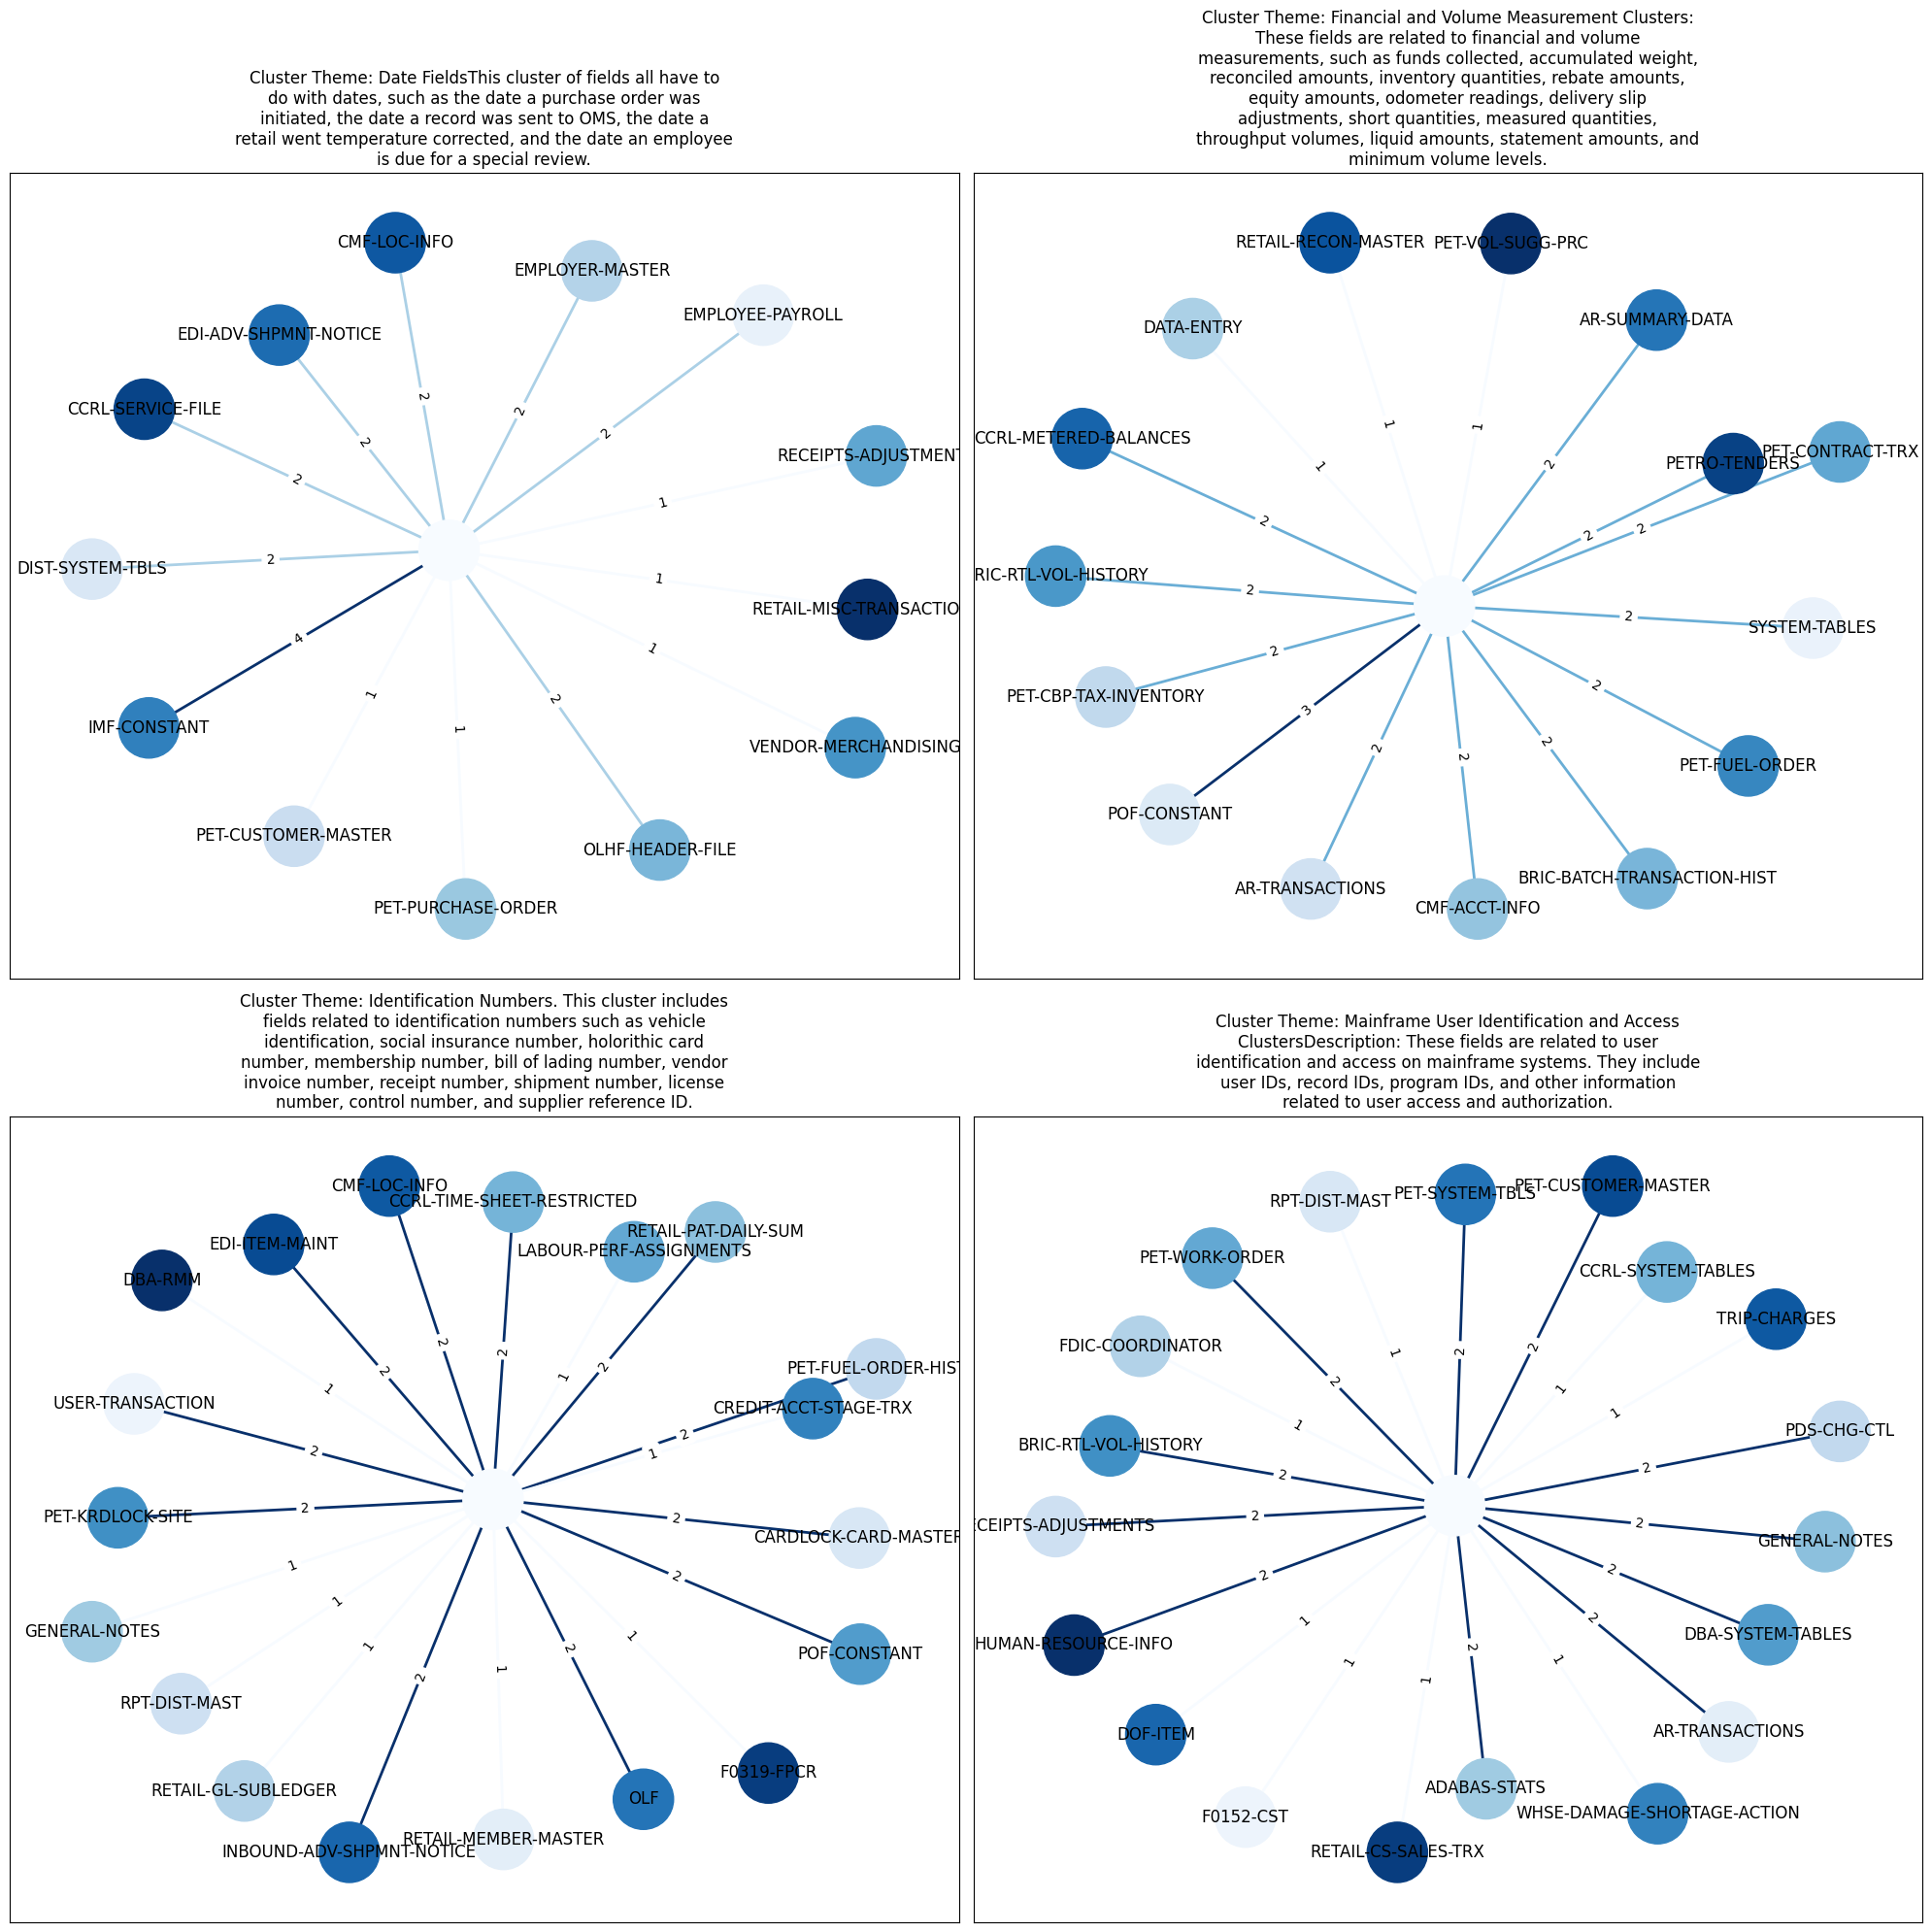

In [12]:
plot_network(results)

## $DBSCAN$ `unsupervised` Clustering Method

### Why DBSCAN

__Challenges with $KMeans$__:

- __K-means__ clustering assumes that the data points are distributed in a spherical shape, which may not always be the case in real-world data sets. This can lead to suboptimal cluster assignments and poor performance on non-spherical data.
- __K-means__ clustering requires the user to specify the number of clusters in advance, which can be difficult to do accurately in many cases. If the number of clusters is not specified correctly, the algorithm may not be able to identify the underlying structure of the data.
- __K-means__ clustering is sensitive to the presence of outliers and noise in the data, which can cause the clusters to be distorted or split into multiple clusters.
- __K-means__ clustering is not well-suited for data sets with uneven cluster sizes or non-linearly separable data, as it may be unable to identify the underlying structure of the data in these cases.

__Advantages of $DBSCAN$__

- DBSCAN does not require the user to specify the number of clusters in advance.
- DBSCAN can handle data sets with varying densities and cluster sizes, as it groups data points into clusters based on density rather than using a fixed number of clusters.
- DBSCAN can identify clusters with arbitrary shapes, as it does not impose any constraints on the shape of the clusters.
- DBSCAN is robust to the presence of noise and outliers in the data, as it can identify clusters even if they are surrounded by points that are not part of the cluster.

## Implementation

In [14]:
#  Find the clusters using K-means
# We show the simplest use of K-means. You can pick the number of clusters that fits your use case best.

from sklearn.cluster import DBSCAN

df_dbs = source.copy()

dbscan = DBSCAN(eps=0.5, min_samples=3)
# Fit dbscan to data
dbscan.fit(matrix)
# Predict cluster labels for each data point
labels_dbs = dbscan.labels_

df_dbs["Cluster"] = labels_dbs

df_dbs.groupby("Cluster").Level.mean().sort_values()

Cluster
 6     1.000000
 16    1.200000
 13    1.200000
 3     1.250000
 9     1.437500
 15    1.545455
-1     1.577586
 0     1.659517
 5     1.666667
 1     1.800000
 2     1.800000
 19    2.000000
 18    2.000000
 17    2.000000
 14    2.000000
 10    2.000000
 11    2.000000
 20    2.000000
 8     2.000000
 7     2.000000
 4     2.000000
 12    2.000000
 21    2.000000
Name: Level, dtype: float64

In [15]:
plot_tsne(data=df_dbs, matrix=matrix, plot_lib=PlotType.PX)

<Figure size 1600x800 with 0 Axes>

In [16]:
results_dbs = embeddings_to_LLM(data=df_dbs, n_clusters=len(pd.unique(df_dbs.Cluster)) - 1, replace=True)

## Cluster 0 Theme:



###  Data Fields Related to Financial TransactionsThis cluster includes fields related to financial transactions such as batch IDs, customer locations, invoice numbers, purchase orders, credit amounts, and dates of changes. These fields are used to track and record financial transactions.





- __RETAIL-DATA-ENTRY__ :A field used to identify the batch being processed. Consists of the user-id that created the record. (2). 



- __CMF-ACCT-INFO__ :SUPERDESCRIPTOR CONSISTS OF:fa FCM-NO FCM-LOC-NO. (1). 



- __CROP-PROTECTION-INVENTORY__ :This field will show the date a change was made to either the last-yr-invt-amt or the fcl-purch-amt (2). 



- __EDI-ITEM-MAINT__ :The date the record was added to the file. (2). 



- __PET-CARDLOCK-PROD-ACCT__ :The date the cardlock card allowances and restrictions status was changed. Format YYYYMMDD. (2). 



- __RETAIL-PAT-TRX__ :Total amount of the patronage keyed in this record. Used to create the Batch record. (1). 



- __IMF-CONSTANT__ :Advertising recovery stop date. (3). 



- __DATA-ENTRY__ :The standard entry invoice amount in FPAY that must be split into future periods. (3). 



- __OLF__ :The purchase order number assigned by the retail.  it may contain alphabetic char- acters. (1). 



- __PET-PURCHASE-ORDER__ :The quantity of product that has been received. (2). 



- __CMF-ACCT-INFO__ :The vendor number to pay out a credit balance. (1). 



- __F0152-CST__ :User id that created or last modified the record. (1). 



- __CCRL-TIME-SHEET__ :The vendor invoice number. (2). 



- __OLHF-LINE-FILE__ :The date on which the invoice was created for this item. (1). 



- __RETAIL-TAX-REMIT__ :The liquor GL Sales amount for the reporting period. Used on the PST remittance report. (2). 



- __RETAIL-DATA-ENTRY__ :The invoice number being posted to the general ledger. (1). 



- __PET-CONTRACT-TRX__ :The amount of credit to the retail for the delivery slip. (2). 



- __RETAIL-MEAT-DIRECTS__ :The date we should start trying to add this item to a DOF Order. (1). 



- __PET-CONTRACT-TRX__ :The RFC delivery slip credit amount. (2). 



- __CMF-LOC-INFO__ :The date on which the status of the customer location became effective. Format 'CCYYMMDD' (2). 



## Cluster 1 Theme:



###  Mainframe Record Definition and Program Identification.This cluster of fields is related to the identification and definition of records and programs used in mainframe systems. It includes fields such as library-id, record definition name, program-id, field format, and direct call.





- __PET-SYSTEM-TBLS__ :The library-id where the record type/id is maintained. (2). 



- __DBA-SYSTEM-TABLES__ :The record definition name used in an ADABAS Direct call or by a program. (Eg: ADCFSTA1  or SGLT3) (2). 



- __PET-SYSTEM-TBLS__ :The program-id of the program that uses a particular record definition. (2). 



- __DBA-SYSTEM-TABLES__ :Field format used for Natural programs. (2). 



- __PET-SYSTEM-TBLS__ :The library-id where the record type/id is maintained. (2). 



- __PET-FUEL-ORDER-HIST__ :The name of the program. This will be used in the new sfpsf2 file definition. (1). 



- __DBA-SYSTEM-TABLES__ :The library-id where the record type/id is maintained. (2). 



- __PET-SYSTEM-TBLS__ :The library-id where the record type/id is maintained. (2). 



- __PET-SYSTEM-TBLS__ :The program-id of the program that uses a particular record definition. (2). 



- __DBA-SYSTEM-TABLES__ :Field format used for Natural programs. (2). 



- __DBA-SYSTEM-TABLES__ :The record definition name used in an ADABAS Direct call or by a program. (Eg: ADCFSTA1  or SGLT3) (2). 



- __PET-SYSTEM-TBLS__ :The program-id of the program that uses a particular record definition. (2). 



- __PET-SYSTEM-TBLS__ :The program-id of the program that uses a particular record definition. (2). 



- __DBA-SYSTEM-TABLES__ :The library-id where the record type/id is maintained. (2). 



- __DBA-SYSTEM-TABLES__ :The library that NPRG is worki ng with. (2). 



- __DBA-SYSTEM-TABLES__ :Field format used for Natural programs. (2). 



- __DBA-SYSTEM-TABLES__ :The ADABAS direct call that uses a particular record definition (ADC). (2). 



- __PET-SYSTEM-TBLS__ :The program-id of the program that uses a particular record definition. (2). 



- __DBA-SYSTEM-TABLES__ :The library that NPRG is worki ng with. (2). 



- __DBA-SYSTEM-TABLES__ :The ADABAS direct call that uses a particular record definition (ADC). (2). 



## Cluster 2 Theme:



###  Remote Identification and Point of Sale Management. These fields are related to the remote identification and management of point of sale systems, such as propane regions, invoice uploads, product numbers, and LBMX invoice images.





- __PET-SYSTEM-TBLS__ :The propane region's remote number. (2). 



- __CMF-LOC-INFO__ :The remote number(s) where the invoice upload file is sent for this location. It is a translation of the remote number into an identification field. eg. rmt094 = RTLCAL1 (2). 



- __PET-PROPANE-RATES__ :The propane product number that is loaded onto the ram cards. (2). 



- __CMF-ACCT-INFO__ :This is the printer location on 0-location cmf records where LBMX invoice images should be printed at. Certain retails want their LMBX invoices printed at different places besides the admin office so we need this field to provide them a place to direct their LMBX printouts. (1). 



- __PET-SYSTEM-TBLS__ :The propane region's remote number. (2). 



- __PET-ETHANOL-BLND-TBL__ :The propane product number that is loaded onto the ram cards. (2). 



- __CMF-LOC-INFO__ :The remote number where the price upload file is sent for this location.  The remote number may be another retails remote number as they may do their pricing. It is a translation of the remote number into an identification field. eg. rmt094 = RTLCAL1 (2). 



- __PET-SYSTEM-TBLS__ :The propane region's remote number. (2). 



- __PET-PROPANE-RATES__ :The propane product number that is loaded onto the ram cards. (2). 



- __CMF-ACCT-INFO__ :This is the printer location on 0-location cmf records where LBMX invoice images should be printed at. Certain retails want their LMBX invoices printed at different places besides the admin office so we need this field to provide them a place to direct their LMBX printouts. (1). 



- __CMF-LOC-INFO__ :The remote number(s) where the invoice upload file is sent for this location. It is a translation of the remote number into an identification field. eg. rmt094 = RTLCAL1 (2). 



- __PET-PROPANE-RATES__ :The propane product number that is loaded onto the ram cards. (2). 



- __PET-PROPANE-RATES__ :The propane product number that is loaded onto the ram cards. (2). 



- __CMF-LOC-INFO__ :The remote number where the price upload file is sent for this location.  The remote number may be another retails remote number as they may do their pricing. It is a translation of the remote number into an identification field. eg. rmt094 = RTLCAL1 (2). 



- __PET-PROPANE-RGNS__ :The propane region's remote number. (2). 



- __CMF-ACCT-INFO__ :This is the printer location on 0-location cmf records where LBMX invoice images should be printed at. Certain retails want their LMBX invoices printed at different places besides the admin office so we need this field to provide them a place to direct their LMBX printouts. (1). 



- __CMF-LOC-INFO__ :This Remote ID is used to send updates to or receive datasets from a Retail's Point of Sale Machine. It is an 8 character field which should contain an R followed by 1 to 7 digits. e.g. R691  R2578  R18 (2). 



- __PET-PROPANE-RATES__ :The propane product number that is loaded onto the ram cards. (2). 



- __PET-PROPANE-RGNS__ :The propane region's remote number. (2). 



- __CMF-LOC-INFO__ :This Remote ID is used to send updates to or receive datasets from a Retail's Point of Sale Machine. It is an 8 character field which should contain an R followed by 1 to 7 digits. e.g. R691  R2578  R18 (2). 



## Cluster 3 Theme:



###  Ecology Codes and Return CodesThe fields in this cluster are related to ecology codes and return codes used to group specific ecology items together. The ecology codes are used to match the value in FDR-REC-CD in DUTY-ETC-RATES file, while the return codes are determined by matching the return codes PST  GST and pack size to the items PST  GST and pack size  where the pack size of the item is the Ecol-Qty/Fcl-Pack.





- __OLHH-LINE-FILE__ :A CODE used to group specific ecology items together. EX. ALL 2 LITRE BOTTLES. Each item on the IMFS system with an ecology code must have a corresponding return code. The return code is determined by matching the return codes PST  GST and pack size to the items PST  GST and pack size  where the pack size of the item is the Ecol-Qty/Fcl-Pack. (1). 



- __POS-IMF-TRX__ :the ecology code matching the value in FDR-REC-CD in DUTY-ETC-RATES file. (1). 



- __OLF__ :A CODE used to group specific ecology items together. EX. ALL 2 LITRE BOTTLES. Each item on the IMFS system with an ecology code must have a corresponding return code. The return code is determined by matching the return codes PST  GST and pack size to the items PST  GST and pack size  where the pack size of the item is the Ecol-Qty/Fcl-Pack. (2). 



- __OLHH-LINE-FILE__ :A CODE used to group specific ecology items together. EX. ALL 2 LITRE BOTTLES. Each item on the IMFS system with an ecology code must have a corresponding return code. The return code is determined by matching the return codes PST  GST and pack size to the items PST  GST and pack size  where the pack size of the item is the Ecol-Qty/Fcl-Pack. (1). 



- __OLHH-LINE-FILE__ :A CODE used to group specific ecology items together. EX. ALL 2 LITRE BOTTLES. Each item on the IMFS system with an ecology code must have a corresponding return code. The return code is determined by matching the return codes PST  GST and pack size to the items PST  GST and pack size  where the pack size of the item is the Ecol-Qty/Fcl-Pack. (1). 



- __POS-IMF-TRX__ :the ecology code matching the value in FDR-REC-CD in DUTY-ETC-RATES file. (1). 



- __OLF__ :A CODE used to group specific ecology items together. EX. ALL 2 LITRE BOTTLES. Each item on the IMFS system with an ecology code must have a corresponding return code. The return code is determined by matching the return codes PST  GST and pack size to the items PST  GST and pack size  where the pack size of the item is the Ecol-Qty/Fcl-Pack. (2). 



- __OLF__ :A CODE used to group specific ecology items together. EX. ALL 2 LITRE BOTTLES. Each item on the IMFS system with an ecology code must have a corresponding return code. The return code is determined by matching the return codes PST  GST and pack size to the items PST  GST and pack size  where the pack size of the item is the Ecol-Qty/Fcl-Pack. (2). 



- __OLHH-LINE-FILE__ :A CODE used to group specific ecology items together. EX. ALL 2 LITRE BOTTLES. Each item on the IMFS system with an ecology code must have a corresponding return code. The return code is determined by matching the return codes PST  GST and pack size to the items PST  GST and pack size  where the pack size of the item is the Ecol-Qty/Fcl-Pack. (1). 



- __OLHF-LINE-FILE__ :A CODE used to group specific ecology items together. EX. ALL 2 LITRE BOTTLES. Each item on the IMFS system with an ecology code must have a corresponding return code. The return code is determined by matching the return codes PST  GST and pack size to the items PST  GST and pack size  where the pack size of the item is the Ecol-Qty/Fcl-Pack. (1). 



- __OLHH-LINE-FILE__ :A CODE used to group specific ecology items together. EX. ALL 2 LITRE BOTTLES. Each item on the IMFS system with an ecology code must have a corresponding return code. The return code is determined by matching the return codes PST  GST and pack size to the items PST  GST and pack size  where the pack size of the item is the Ecol-Qty/Fcl-Pack. (1). 



- __OLHH-LINE-FILE__ :A CODE used to group specific ecology items together. EX. ALL 2 LITRE BOTTLES. Each item on the IMFS system with an ecology code must have a corresponding return code. The return code is determined by matching the return codes PST  GST and pack size to the items PST  GST and pack size  where the pack size of the item is the Ecol-Qty/Fcl-Pack. (1). 



- __OLHH-LINE-FILE__ :A CODE used to group specific ecology items together. EX. ALL 2 LITRE BOTTLES. Each item on the IMFS system with an ecology code must have a corresponding return code. The return code is determined by matching the return codes PST  GST and pack size to the items PST  GST and pack size  where the pack size of the item is the Ecol-Qty/Fcl-Pack. (1). 



- __OLHH-LINE-FILE__ :A CODE used to group specific ecology items together. EX. ALL 2 LITRE BOTTLES. Each item on the IMFS system with an ecology code must have a corresponding return code. The return code is determined by matching the return codes PST  GST and pack size to the items PST  GST and pack size  where the pack size of the item is the Ecol-Qty/Fcl-Pack. (1). 



- __POS-IMF-TRX__ :the ecology code matching the value in FDR-REC-CD in DUTY-ETC-RATES file. (1). 



- __OLF__ :A CODE used to group specific ecology items together. EX. ALL 2 LITRE BOTTLES. Each item on the IMFS system with an ecology code must have a corresponding return code. The return code is determined by matching the return codes PST  GST and pack size to the items PST  GST and pack size  where the pack size of the item is the Ecol-Qty/Fcl-Pack. (2). 



- __POS-IMF-TRX__ :the ecology code matching the value in FDR-REC-CD in DUTY-ETC-RATES file. (1). 



- __POS-IMF-TRX__ :the ecology code matching the value in FDR-REC-CD in DUTY-ETC-RATES file. (1). 



- __POS-IMF-TRX__ :the ecology code matching the value in FDR-REC-CD in DUTY-ETC-RATES file. (1). 



- __OLHH-LINE-FILE__ :A CODE used to group specific ecology items together. EX. ALL 2 LITRE BOTTLES. Each item on the IMFS system with an ecology code must have a corresponding return code. The return code is determined by matching the return codes PST  GST and pack size to the items PST  GST and pack size  where the pack size of the item is the Ecol-Qty/Fcl-Pack. (1). 



## Cluster 4 Theme:



###  These fields are related to the description of the size, weight, or volume of one unit of a petroleum item.





- __PET-CONTRACT-TRX__ :The description of the size  weight or volume of one unit of a petroleum item. (ie. 205 Litre). (2). 



- __PET-OIL-ORDER__ :The description of the size  weight or volume of one unit of a petroleum item. (ie. 205 Litre). (2). 



- __PET-CONTRACT-TRX__ :The description of the size  weight or volume of one unit of a petroleum item. (ie. 205 Litre). (2). 



- __PET-CONTRACT-TRX__ :The description of the size  weight or volume of one unit of a petroleum item. (ie. 205 Litre). (2). 



- __PET-OIL-ORDER__ :The description of the size  weight or volume of one unit of a petroleum item. (ie. 205 Litre). (2). 



- __PET-OIL-ORDER__ :The description of the size  weight or volume of one unit of a petroleum item. (ie. 205 Litre). (2). 



- __PET-CONTRACT-TRX__ :The description of the size  weight or volume of one unit of a petroleum item. (ie. 205 Litre). (2). 



- __PET-SYSTEM-TBLS__ :The description of the size  weight or volume of one unit of a petroleum item. (ie. 205 Litre). (2). 



- __PET-CONTRACT-TRX__ :The description of the size  weight or volume of one unit of a petroleum item. (ie. 205 Litre). (2). 



- __PET-CONTRACT-TRX__ :The description of the size  weight or volume of one unit of a petroleum item. (ie. 205 Litre). (2). 



- __PET-CONTRACT-TRX__ :The description of the size  weight or volume of one unit of a petroleum item. (ie. 205 Litre). (2). 



- __PET-CONTRACT-TRX__ :The description of the size  weight or volume of one unit of a petroleum item. (ie. 205 Litre). (2). 



- __PET-OIL-ORDER__ :The description of the size  weight or volume of one unit of a petroleum item. (ie. 205 Litre). (2). 



- __PET-CONTRACT-TRX__ :The description of the size  weight or volume of one unit of a petroleum item. (ie. 205 Litre). (2). 



- __PET-SYSTEM-TBLS__ :The description of the size  weight or volume of one unit of a petroleum item. (ie. 205 Litre). (2). 



- __PET-OIL-ORDER__ :The description of the size  weight or volume of one unit of a petroleum item. (ie. 205 Litre). (2). 



- __PET-SYSTEM-TBLS__ :The description of the size  weight or volume of one unit of a petroleum item. (ie. 205 Litre). (2). 



- __PET-SYSTEM-TBLS__ :The description of the size  weight or volume of one unit of a petroleum item. (ie. 205 Litre). (2). 



- __PET-SYSTEM-TBLS__ :The description of the size  weight or volume of one unit of a petroleum item. (ie. 205 Litre). (2). 



- __PET-SYSTEM-TBLS__ :The description of the size  weight or volume of one unit of a petroleum item. (ie. 205 Litre). (2). 



## Cluster 5 Theme:



###  Mainframe Printer Clusters: These fields are related to the mainframe printer system, and are used to determine where reports are to be printed when they are requested. They include fields such as FDST-RUN-NA, FST-PRNTR-DEST-ID, FDST-PRNTR-ID, and FDST-PRT-DESC.





- __DIST-SYSTEM-TBLS__ :The job name the printers are for. (2). 



- __BRIC-REMOTE-PRINT-TBL__ :This field contains the destination-ids or printer-ids of users. It is used in conjunction with the field FST-USER-ID to determine where reports are to be printed when they are requested. (1). 



- __DIST-SYSTEM-TBLS__ :The printer where the report is to be printed on for the specified job and step (2). 



- __BRIC-REMOTE-PRINT-TBL__ :This field contains the destination-ids or printer-ids of users. It is used in conjunction with the field FST-USER-ID to determine where reports are to be printed when they are requested. (1). 



- __BRIC-REMOTE-PRINT-TBL__ :This field contains the destination-ids or printer-ids of users. It is used in conjunction with the field FST-USER-ID to determine where reports are to be printed when they are requested. (1). 



- __DIST-SYSTEM-TBLS__ :Printer Destination (2). 



- __DIST-SYSTEM-TBLS__ :The printer where the report is to be printed on for the specified job and step (2). 



- __DIST-SYSTEM-TBLS__ :The printer where the report is to be printed on for the specified job and step (2). 



- __DIST-SYSTEM-TBLS__ :The printer where the report is to be printed on for the specified job and step (2). 



- __BRIC-REMOTE-PRINT-TBL__ :This field contains the destination-ids or printer-ids of users. It is used in conjunction with the field FST-USER-ID to determine where reports are to be printed when they are requested. (1). 



- __DIST-SYSTEM-TBLS__ :The job name the printers are for. (2). 



- __DIST-SYSTEM-TBLS__ :The printer where the report is to be printed on for the specified job and step (2). 



- __PET-SYSTEM-TBLS__ :This field contains the destination-ids or printer-ids of users. It is used in conjunction with the field FST-USER-ID to determine where reports are to be printed when they are requested. (2). 



- __BRIC-REMOTE-PRINT-TBL__ :This field contains the destination-ids or printer-ids of users. It is used in conjunction with the field FST-USER-ID to determine where reports are to be printed when they are requested. (1). 



- __DIST-SYSTEM-TBLS__ :Printer Destination (2). 



- __DIST-SYSTEM-TBLS__ :The job name the printers are for. (2). 



- __PET-SYSTEM-TBLS__ :This field contains the destination-ids or printer-ids of users. It is used in conjunction with the field FST-USER-ID to determine where reports are to be printed when they are requested. (2). 



- __PET-SYSTEM-TBLS__ :This field contains the destination-ids or printer-ids of users. It is used in conjunction with the field FST-USER-ID to determine where reports are to be printed when they are requested. (2). 



- __DIST-SYSTEM-TBLS__ :Printer Destination (2). 



- __DIST-SYSTEM-TBLS__ :The job name the printers are for. (2). 



## Cluster 6 Theme:



###  Mainframe Transaction Identification. These fields are all related to the identification of transactions used by an application on a mainframe. The assigned values indicate the type of transaction, such as item/price upload, promotion records to send to TCI, or items that are to have retail selling prices uploaded to particular retail.





- __RMM-UPD-REC__ :Transaction identification used by an application. Assigned values to-date: IMFPOS   - Item/price upload PROMSCAN - TGP prom scan upd TCIUPLD  - Promotion records  to send to TCI. POSNEW   - New food direct  item for FCL upload wait 1  work day before send out. PROMUPLD - FCL Prom Upload rec UPLDPRC  - Items that are to  have retail selling prices  uploaded to particular retail (1). 



- __PET-LIC-TRX__ :Transaction identification used by an application. Assigned values to-date: IMFPOS   - Item/price upload PROMSCAN - TGP prom scan upd TCIUPLD  - Promotion records  to send to TCI. POSNEW   - New food direct  item for FCL upload wait 1  work day before send out. PROMUPLD - FCL Prom Upload rec UPLDPRC  - Items that are to  have retail selling prices  uploaded to particular retail (1). 



- __PET-DISCOUNT-TRX__ :Transaction identification used by an application. Assigned values to-date: IMFPOS   - Item/price upload PROMSCAN - TGP prom scan upd TCIUPLD  - Promotion records  to send to TCI. POSNEW   - New food direct  item for FCL upload wait 1  work day before send out. PROMUPLD - FCL Prom Upload rec UPLDPRC  - Items that are to  have retail selling prices  uploaded to particular retail (1). 



- __PET-LIC-TRX__ :Transaction identification used by an application. Assigned values to-date: IMFPOS   - Item/price upload PROMSCAN - TGP prom scan upd TCIUPLD  - Promotion records  to send to TCI. POSNEW   - New food direct  item for FCL upload wait 1  work day before send out. PROMUPLD - FCL Prom Upload rec UPLDPRC  - Items that are to  have retail selling prices  uploaded to particular retail (1). 



- __PET-LIC-TRX__ :Transaction identification used by an application. Assigned values to-date: IMFPOS   - Item/price upload PROMSCAN - TGP prom scan upd TCIUPLD  - Promotion records  to send to TCI. POSNEW   - New food direct  item for FCL upload wait 1  work day before send out. PROMUPLD - FCL Prom Upload rec UPLDPRC  - Items that are to  have retail selling prices  uploaded to particular retail (1). 



- __PAYRL-VACTN-DEDN-TRX__ :Transaction identification used by an application. Assigned values to-date: IMFPOS   - Item/price upload PROMSCAN - TGP prom scan upd TCIUPLD  - Promotion records  to send to TCI. POSNEW   - New food direct  item for FCL upload wait 1  work day before send out. PROMUPLD - FCL Prom Upload rec UPLDPRC  - Items that are to  have retail selling prices  uploaded to particular retail (1). 



- __PET-DISCOUNT-TRX__ :Transaction identification used by an application. Assigned values to-date: IMFPOS   - Item/price upload PROMSCAN - TGP prom scan upd TCIUPLD  - Promotion records  to send to TCI. POSNEW   - New food direct  item for FCL upload wait 1  work day before send out. PROMUPLD - FCL Prom Upload rec UPLDPRC  - Items that are to  have retail selling prices  uploaded to particular retail (1). 



- __PET-DISCOUNT-TRX__ :Transaction identification used by an application. Assigned values to-date: IMFPOS   - Item/price upload PROMSCAN - TGP prom scan upd TCIUPLD  - Promotion records  to send to TCI. POSNEW   - New food direct  item for FCL upload wait 1  work day before send out. PROMUPLD - FCL Prom Upload rec UPLDPRC  - Items that are to  have retail selling prices  uploaded to particular retail (1). 



- __PET-DISCOUNT-TRX__ :Transaction identification used by an application. Assigned values to-date: IMFPOS   - Item/price upload PROMSCAN - TGP prom scan upd TCIUPLD  - Promotion records  to send to TCI. POSNEW   - New food direct  item for FCL upload wait 1  work day before send out. PROMUPLD - FCL Prom Upload rec UPLDPRC  - Items that are to  have retail selling prices  uploaded to particular retail (1). 



- __PET-LIC-TRX__ :Transaction identification used by an application. Assigned values to-date: IMFPOS   - Item/price upload PROMSCAN - TGP prom scan upd TCIUPLD  - Promotion records  to send to TCI. POSNEW   - New food direct  item for FCL upload wait 1  work day before send out. PROMUPLD - FCL Prom Upload rec UPLDPRC  - Items that are to  have retail selling prices  uploaded to particular retail (1). 



- __RMM-UPD-REC__ :Transaction identification used by an application. Assigned values to-date: IMFPOS   - Item/price upload PROMSCAN - TGP prom scan upd TCIUPLD  - Promotion records  to send to TCI. POSNEW   - New food direct  item for FCL upload wait 1  work day before send out. PROMUPLD - FCL Prom Upload rec UPLDPRC  - Items that are to  have retail selling prices  uploaded to particular retail (1). 



- __PET-DISCOUNT-TRX__ :Transaction identification used by an application. Assigned values to-date: IMFPOS   - Item/price upload PROMSCAN - TGP prom scan upd TCIUPLD  - Promotion records  to send to TCI. POSNEW   - New food direct  item for FCL upload wait 1  work day before send out. PROMUPLD - FCL Prom Upload rec UPLDPRC  - Items that are to  have retail selling prices  uploaded to particular retail (1). 



- __PET-LIC-TRX__ :Transaction identification used by an application. Assigned values to-date: IMFPOS   - Item/price upload PROMSCAN - TGP prom scan upd TCIUPLD  - Promotion records  to send to TCI. POSNEW   - New food direct  item for FCL upload wait 1  work day before send out. PROMUPLD - FCL Prom Upload rec UPLDPRC  - Items that are to  have retail selling prices  uploaded to particular retail (1). 



- __PAYRL-VACTN-DEDN-TRX__ :Transaction identification used by an application. Assigned values to-date: IMFPOS   - Item/price upload PROMSCAN - TGP prom scan upd TCIUPLD  - Promotion records  to send to TCI. POSNEW   - New food direct  item for FCL upload wait 1  work day before send out. PROMUPLD - FCL Prom Upload rec UPLDPRC  - Items that are to  have retail selling prices  uploaded to particular retail (1). 



- __RMM-UPD-REC__ :Transaction identification used by an application. Assigned values to-date: IMFPOS   - Item/price upload PROMSCAN - TGP prom scan upd TCIUPLD  - Promotion records  to send to TCI. POSNEW   - New food direct  item for FCL upload wait 1  work day before send out. PROMUPLD - FCL Prom Upload rec UPLDPRC  - Items that are to  have retail selling prices  uploaded to particular retail (1). 



- __PAYRL-VACTN-DEDN-TRX__ :Transaction identification used by an application. Assigned values to-date: IMFPOS   - Item/price upload PROMSCAN - TGP prom scan upd TCIUPLD  - Promotion records  to send to TCI. POSNEW   - New food direct  item for FCL upload wait 1  work day before send out. PROMUPLD - FCL Prom Upload rec UPLDPRC  - Items that are to  have retail selling prices  uploaded to particular retail (1). 



- __RMM-UPD-REC__ :Transaction identification used by an application. Assigned values to-date: IMFPOS   - Item/price upload PROMSCAN - TGP prom scan upd TCIUPLD  - Promotion records  to send to TCI. POSNEW   - New food direct  item for FCL upload wait 1  work day before send out. PROMUPLD - FCL Prom Upload rec UPLDPRC  - Items that are to  have retail selling prices  uploaded to particular retail (1). 



- __PET-LIC-TRX__ :Transaction identification used by an application. Assigned values to-date: IMFPOS   - Item/price upload PROMSCAN - TGP prom scan upd TCIUPLD  - Promotion records  to send to TCI. POSNEW   - New food direct  item for FCL upload wait 1  work day before send out. PROMUPLD - FCL Prom Upload rec UPLDPRC  - Items that are to  have retail selling prices  uploaded to particular retail (1). 



- __POS-IMF-TRX__ :Transaction identification used by an application. Assigned values to-date: IMFPOS   - Item/price upload PROMSCAN - TGP prom scan upd TCIUPLD  - Promotion records  to send to TCI. POSNEW   - New food direct  item for FCL upload wait 1  work day before send out. PROMUPLD - FCL Prom Upload rec UPLDPRC  - Items that are to  have retail selling prices  uploaded to particular retail (1). 



- __RMM-UPD-REC__ :Transaction identification used by an application. Assigned values to-date: IMFPOS   - Item/price upload PROMSCAN - TGP prom scan upd TCIUPLD  - Promotion records  to send to TCI. POSNEW   - New food direct  item for FCL upload wait 1  work day before send out. PROMUPLD - FCL Prom Upload rec UPLDPRC  - Items that are to  have retail selling prices  uploaded to particular retail (1). 



## Cluster 7 Theme:



###  Payment Processing ClustersDescription: These fields are related to payment processing, such as merchant numbers for Mastercard and Visa, and terminal IDs for Moneris debit/credit card terminals.





- __CMF-LOC-INFO__ :The MASTERCARD merchant number of a retail.  Each customer has a unique merchant number. (2). 



- __CMF-LOC-INFO__ :The VISA card merchant number of a retail.  Each customer has a unique merchant number. (2). 



- __CMF-LOC-INFO__ :The serial number of a Moneris debit/credit card terminal used at an FCL retail. . Transactions for Co-op Credit Cards will be transmitted to FCL via this machine. (2). 



- __CMF-LOC-INFO__ :The MASTERCARD merchant number of a retail.  Each customer has a unique merchant number. (2). 



- __CMF-LOC-INFO__ :The MASTERCARD merchant number of a retail.  Each customer has a unique merchant number. (2). 



- __CMF-LOC-INFO__ :The VISA card merchant number of a retail.  Each customer has a unique merchant number. (2). 



- __CMF-LOC-INFO__ :The serial number of a Moneris debit/credit card terminal used at an FCL retail. . Transactions for Co-op Credit Cards will be transmitted to FCL via this machine. (2). 



- __CMF-LOC-INFO__ :The serial number of a Moneris debit/credit card terminal used at an FCL retail. . Transactions for Co-op Credit Cards will be transmitted to FCL via this machine. (2). 



- __CMF-LOC-INFO__ :The MASTERCARD merchant number of a retail.  Each customer has a unique merchant number. (2). 



- __CMF-LOC-INFO__ :The MASTERCARD merchant number of a retail.  Each customer has a unique merchant number. There are 2 occurrances  the first is the regular mc merchant number  the 2nd is if there's a 'pay-at-the-pump' machine which requires its own unique mc merchant number  according to moneris. (2). 



- __CMF-LOC-INFO__ :The MASTERCARD merchant number of a retail.  Each customer has a unique merchant number. (2). 



- __CMF-LOC-INFO__ :The MASTERCARD merchant number of a retail.  Each customer has a unique merchant number. (2). 



- __CMF-LOC-INFO__ :The MASTERCARD merchant number of a retail.  Each customer has a unique merchant number. (2). 



- __CMF-LOC-INFO__ :The MASTERCARD merchant number of a retail.  Each customer has a unique merchant number. (2). 



- __CMF-LOC-INFO__ :The VISA card merchant number of a retail.  Each customer has a unique merchant number. (2). 



- __CMF-LOC-INFO__ :The serial number of a Moneris debit/credit card terminal used at an FCL retail. . Transactions for Co-op Credit Cards will be transmitted to FCL via this machine. (2). 



- __CMF-LOC-INFO__ :The VISA card merchant number of a retail.  Each customer has a unique merchant number. (2). 



- __CMF-LOC-INFO__ :The VISA card merchant number of a retail.  Each customer has a unique merchant number. (2). 



- __CMF-LOC-INFO__ :The VISA card merchant number of a retail.  Each customer has a unique merchant number. (2). 



- __CMF-LOC-INFO__ :The MASTERCARD merchant number of a retail.  Each customer has a unique merchant number. (2). 



## Cluster 8 Theme:



###  Mainframe User and Date Tracking. These fields are related to tracking the user and date of when a production panvalet member is copied to test, when a duplicate copy is created in test, and when the program is returned back to production.





- __PDS-CHG-CTL__ :The user id identifying the person copying the production panvalet member to test. (2). 



- __PDS-CHG-CTL__ :The user id indicating the user that returned the program back to production. (2). 



- __PDS-CHG-CTL__ :The date that the panvalet member was copied to test by the initial user. (2). 



- __PDS-CHG-CTL__ :The user id identifying the person copying the production panvalet member to test. (2). 



- __PDS-CHG-CTL__ :The date that a duplicate copy of a panvalet member was created in test by a second user. (2). 



- __PDS-CHG-CTL__ :The date that the panvalet member was copied to test by the initial user. (2). 



- __PDS-CHG-CTL__ :The date that the panvalet member was copied to test by the initial user. (2). 



- __PDS-CHG-CTL__ :The user id identifying the person copying the production panvalet member to test. (2). 



- __PDS-CHG-CTL__ :The userid indicating the user that created a second copy of a panvalet member in test. (2). 



- __PDS-CHG-CTL__ :The date that a duplicate copy of a panvalet member was created in test by a second user. (2). 



- __PDS-CHG-CTL__ :The user id identifying the person copying the production panvalet member to test. (2). 



- __PDS-CHG-CTL__ :The date that a duplicate copy of a panvalet member was created in test by a second user. (2). 



- __PDS-CHG-CTL__ :The date that a duplicate copy of a panvalet member was created in test by a second user. (2). 



- __PDS-CHG-CTL__ :The date that the panvalet member was copied to test by the initial user. (2). 



- __PDS-CHG-CTL__ :The user id indicating the user that returned the program back to production. (2). 



- __PDS-CHG-CTL__ :The date that a duplicate copy of a panvalet member was created in test by a second user. (2). 



- __PDS-CHG-CTL__ :The name of the panvalet member being copied or replaced. (2). 



- __PDS-CHG-CTL__ :The date that the panvalet member was copied to test by the initial user. (2). 



- __PDS-CHG-CTL__ :The userid indicating the user that created a second copy of a panvalet member in test. (2). 



- __PDS-CHG-CTL__ :The user id indicating the user that returned the program back to production. (2). 



## Cluster 9 Theme:



###  Volume and DiscountsThese fields are related to the volume and discounts associated with a particular customer or retail member. They include the minimum and maximum volume levels in which a discount applies, the yearly patronage dollar amount, and the volume in litres of the patronage transaction type.





- __PET-VOL-SUGG-PRC__ :The previous minimum volume level in which a particular discount applies to a customer. (1). 



- __PET-VOL-SUGG-PRC__ :The maximum volume level in which a particular discount applies to a customer. (1). 



- __DBA-RMM__ :This field contains the yearly patronage dollar amount of a retail member.  There will be many occurrences with: 1st occ = curr. amt - this yr 2nd occ = curr. amt - next yr 3rd occ = previous yr1 amount 4th occ = previous yr2 amount 5th occ = previous yr3 amount (2). 



- __RMM-UPD-REC__ :This field contains the yearly patronage dollar amount of a retail member.  There will be many occurrences with: 1st occ = curr. amt - this yr 2nd occ = curr. amt - next yr 3rd occ = previous yr1 amount 4th occ = previous yr2 amount 5th occ = previous yr3 amount (1). 



- __RETAIL-PAT-DAILY-DTL__ :The volume in litres of the patronage transaction type as applied to the retail member. (2). 



- __RETAIL-PAT-TRX__ :The volume in litres of the patronage transaction type as applied to the retail member. (2). 



- __DBA-RMM__ :This field contains the yearly patronage dollar amount of a retail member.  There will be many occurrences with: 1st occ = curr. amt - this yr 2nd occ = curr. amt - next yr 3rd occ = previous yr1 amount 4th occ = previous yr2 amount 5th occ = previous yr3 amount (2). 



- __BRIC-MBR-PROD-DISCOUNT__ :The maximum volume level in which a particular discount applies to a customer. (1). 



- __PET-VOL-SUGG-PRC__ :The previous minimum volume level in which a particular discount applies to a customer. (1). 



- __RETAIL-MEMBER-MASTER__ :The volume in litres of the patronage transaction type as applied to the retail member. (2). 



- __PET-VOL-SUGG-PRC__ :The minimum volume level in which a particular discount applies to a customer. (1). 



- __PET-VOL-SUGG-PRC__ :The previous minimum volume level in which a particular discount applies to a customer. (1). 



- __RETAIL-PAT-DAILY-DTL__ :The volume in litres of the patronage transaction type as applied to the retail member. (2). 



- __RETAIL-PAT-DAILY-DTL__ :The volume in litres of the patronage transaction type as applied to the retail member. (2). 



- __RETAIL-PAT-TRX__ :The volume in litres of the patronage transaction type as applied to the retail member. (2). 



- __BRIC-MBR-PROD-DISCOUNT__ :The maximum volume level in which a particular discount applies to a customer. (1). 



- __PET-VOL-SUGG-PRC__ :The maximum volume level in which a particular discount applies to a customer. (1). 



- __RETAIL-PAT-TRX__ :The volume in litres of the patronage transaction type as applied to the retail member. (2). 



- __RETAIL-PAT-TRX__ :The volume in litres of the patronage transaction type as applied to the retail member. (2). 



- __PET-VOL-SUGG-PRC__ :The minimum volume level in which a particular discount applies to a customer. (1). 



## Cluster 10 Theme:



###  These fields are related to the projected volume of a member at the time of sale or when the BRIC transaction was created.





- __BRIC-BATCH-TRANSACTION-HIST__ :This is the member's projected volume at time of sale or when the BRIC transaction was created. (2). 



- __F0310-RBBT__ :This is the member's projected volume at time of sale or when the BRIC transaction was created. (2). 



- __BRIC-BATCH-TRANSACTION-HIST__ :This is the member's projected volume at time of sale or when the BRIC transaction was created. (2). 



- __BRIC-BATCH-TRANSACTION-HIST__ :This is the member's projected volume at time of sale or when the BRIC transaction was created. (2). 



- __F0310-RBBT__ :This is the member's projected volume at time of sale or when the BRIC transaction was created. (2). 



- __F0310-RBBT__ :This is the member's projected volume at time of sale or when the BRIC transaction was created. (2). 



- __BRIC-BATCH-TRANSACTION-HIST__ :This is the member's projected volume at time of sale or when the BRIC transaction was created. (2). 



- __BRIC-BATCH-TRANSACTION__ :This is the member's projected volume at time of sale or when the BRIC transaction was created. (2). 



- __BRIC-BATCH-TRANSACTION-HIST__ :This is the member's projected volume at time of sale or when the BRIC transaction was created. (2). 



- __BRIC-BATCH-TRANSACTION-HIST__ :This is the member's projected volume at time of sale or when the BRIC transaction was created. (2). 



- __BRIC-BATCH-TRANSACTION-HIST__ :This is the member's projected volume at time of sale or when the BRIC transaction was created. (2). 



- __BRIC-BATCH-TRANSACTION-HIST__ :This is the member's projected volume at time of sale or when the BRIC transaction was created. (2). 



- __F0310-RBBT__ :This is the member's projected volume at time of sale or when the BRIC transaction was created. (2). 



- __BRIC-BATCH-TRANSACTION-HIST__ :This is the member's projected volume at time of sale or when the BRIC transaction was created. (2). 



- __BRIC-BATCH-TRANSACTION__ :This is the member's projected volume at time of sale or when the BRIC transaction was created. (2). 



- __F0310-RBBT__ :This is the member's projected volume at time of sale or when the BRIC transaction was created. (2). 



- __BRIC-BATCH-TRANSACTION__ :This is the member's projected volume at time of sale or when the BRIC transaction was created. (2). 



- __BRIC-BATCH-TRANSACTION__ :This is the member's projected volume at time of sale or when the BRIC transaction was created. (2). 



- __BRIC-BATCH-TRANSACTION__ :This is the member's projected volume at time of sale or when the BRIC transaction was created. (2). 



- __BRIC-BATCH-TRANSACTION__ :This is the member's projected volume at time of sale or when the BRIC transaction was created. (2). 



## Cluster 11 Theme:



###  Mainframe JCL Field ReplacementsDescription: This cluster of fields is related to the dynamic field replacement information that is inserted into the JCL and the &CC* replacements from the Natural stack that are used in the appended JCL member.





- __BATCH-JOB-TRACKING__ :The dynamic field replacement information that was inserted into the JCL. (2). 



- __BATCH-JOB-TRACKING__ :The &CC* replacements from the Natural stack that were used in the appended JCL member. (2). 



- __BATCH-JOB-TRACKING__ :The dynamic field replacement information that was inserted into the JCL. (2). 



- __BATCH-JOB-TRACKING__ :The dynamic field replacement information that was inserted into the JCL. (2). 



- __BATCH-JOB-TRACKING__ :The &CC* replacements from the Natural stack that were used in the appended JCL member. (2). 



- __BATCH-JOB-TRACKING__ :The &CC* replacements from the Natural stack that were used in the appended JCL member. (2). 



- __BATCH-JOB-TRACKING__ :The dynamic field replacement information that was inserted into the JCL. (2). 



- __BATCH-JOB-TRACKING__ :The dynamic replacement information passed to the JCL source using the Natural stack (2). 



- __BATCH-JOB-TRACKING__ :The dynamic field replacement information that was inserted into the JCL. (2). 



- __BATCH-JOB-TRACKING__ :The dynamic field replacement information that was inserted into the JCL. (2). 



- __BATCH-JOB-TRACKING__ :The dynamic field replacement information that was inserted into the JCL. (2). 



- __BATCH-JOB-TRACKING__ :The dynamic field replacement information that was inserted into the JCL. (2). 



- __BATCH-JOB-TRACKING__ :The &CC* replacements from the Natural stack that were used in the appended JCL member. (2). 



- __BATCH-JOB-TRACKING__ :The dynamic field replacement information that was inserted into the JCL. (2). 



- __BATCH-JOB-TRACKING__ :The dynamic replacement information passed to the JCL source using the Natural stack (2). 



- __BATCH-JOB-TRACKING__ :The &CC* replacements from the Natural stack that were used in the appended JCL member. (2). 



- __BATCH-JOB-TRACKING__ :The dynamic replacement information passed to the JCL source using the Natural stack (2). 



- __BATCH-JOB-TRACKING__ :The dynamic replacement information passed to the JCL source using the Natural stack (2). 



- __BATCH-JOB-TRACKING__ :The dynamic replacement information passed to the JCL source using the Natural stack (2). 



- __BATCH-JOB-TRACKING__ :The dynamic replacement information passed to the JCL source using the Natural stack (2). 



## Cluster 12 Theme:



###  Email AddressesThe fields in this cluster have to do with email addresses, such as forwarding email addresses and generic email addresses.





- __PAYROLL-MISC-TBLS__ :Forwarding email address that belongs to the CRS ID (2). 



- __EMPL-PAY-SUBLGR__ :This a generic email address field. (2). 



- __PAYROLL-MISC-TBLS__ :Forwarding email address that belongs to the CRS ID (2). 



- __PAYROLL-MISC-TBLS__ :Forwarding email address that belongs to the CRS ID (2). 



- __EMPL-PAY-SUBLGR__ :This a generic email address field. (2). 



- __EMPL-PAY-SUBLGR__ :This a generic email address field. (2). 



- __PAYROLL-MISC-TBLS__ :Forwarding email address that belongs to the CRS ID (2). 



- __PAYROLL-MISC-TBLS__ :This a generic email address field. (2). 



- __PAYROLL-MISC-TBLS__ :Forwarding email address that belongs to the CRS ID (2). 



- __PAYROLL-MISC-TBLS__ :Forwarding email address that belongs to the CRS ID (2). 



- __PAYROLL-MISC-TBLS__ :Forwarding email address that belongs to the CRS ID (2). 



- __PAYROLL-MISC-TBLS__ :Forwarding email address that belongs to the CRS ID (2). 



- __EMPL-PAY-SUBLGR__ :This a generic email address field. (2). 



- __PAYROLL-MISC-TBLS__ :Forwarding email address that belongs to the CRS ID (2). 



- __PAYROLL-MISC-TBLS__ :This a generic email address field. (2). 



- __EMPL-PAY-SUBLGR__ :This a generic email address field. (2). 



- __PAYROLL-MISC-TBLS__ :This a generic email address field. (2). 



- __PAYROLL-MISC-TBLS__ :This a generic email address field. (2). 



- __PAYROLL-MISC-TBLS__ :This a generic email address field. (2). 



- __PAYROLL-MISC-TBLS__ :This a generic email address field. (2). 



## Cluster 13 Theme:



###  These fields are all related to the mainframe and were incorporated from FDT on 97-02-19.





- __FDIC-COORDINATOR__ :This field was incorporated from FDT on 97-02-19 (1). 



- __FDIC-COORDINATOR__ :This field was incorporated from FDT on 97-02-19 (1). 



- __FDIC-COORDINATOR__ :This field was incorporated from FDT on 97-02-19 (1). 



- __FDIC-COORDINATOR__ :This field was incorporated from FDT on 97-02-19 (1). 



- __FDIC-COORDINATOR__ :This field was incorporated from FDT on 97-02-19 (1). 



- __FDIC-COORDINATOR__ :This field was incorporated from FDT on 97-02-19 (1). 



- __FDIC-COORDINATOR__ :This field was incorporated from FDT on 97-02-19 (1). 



- __FDIC-COORDINATOR__ :This field was incorporated from FDT on 97-02-19 (1). 



- __FDIC-COORDINATOR__ :This field was incorporated from FDT on 97-02-19 (1). 



- __FDIC-COORDINATOR__ :This field was incorporated from FDT on 97-02-19 (1). 



- __FDIC-COORDINATOR__ :This field was incorporated from FDT on 97-02-19 (1). 



- __FDIC-COORDINATOR__ :This field was incorporated from FDT on 97-02-19 (1). 



- __FDIC-COORDINATOR__ :This field was incorporated from FDT on 97-02-19 (1). 



- __FDIC-COORDINATOR__ :This field was incorporated from FDT on 97-02-19 (1). 



- __FDIC-COORDINATOR__ :This field was incorporated from FDT on 97-02-19 (1). 



- __FDIC-COORDINATOR__ :This field was incorporated from FDT on 97-02-19 (1). 



- __FDIC-COORDINATOR__ :This field was incorporated from FDT on 97-02-19 (1). 



- __FDIC-COORDINATOR__ :This field was incorporated from FDT on 97-02-19 (1). 



- __FDIC-COORDINATOR__ :This field was incorporated from FDT on 97-02-19 (2). 



- __FDIC-COORDINATOR__ :This field was incorporated from FDT on 97-02-19 (1). 



## Cluster 14 Theme:



###  Card Number Assignment Clusters: These fields are related to the assignment of card numbers, including the starting and ending card numbers of a primary and secondary range, as well as the current card number being issued.





- __PET-KRDLOCK-SITE__ :The starting card number of a secondary range of numbers to be used when the current range is all used. (2). 



- __PET-KRDLOCK-SITE__ :The ending card number of a secondary range of numbers to be used when the current range is all used. (2). 



- __PET-KRDLOCK-SITE__ :The next card number to be issued during card assignment. (2). 



- __PET-KRDLOCK-SITE__ :The ending card number of a secondary range of numbers to be used when the current range is all used. (2). 



- __PET-KRDLOCK-SITE__ :The ending card number of a secondary range of numbers to be used when the current range is all used. (2). 



- __PET-KRDLOCK-SITE__ :The starting card number to be used to assign cards. (2). 



- __PET-KRDLOCK-SITE__ :The next card number to be issued during card assignment. (2). 



- __PET-KRDLOCK-SITE__ :The next card number to be issued during card assignment. (2). 



- __PET-KRDLOCK-SITE__ :The next card number to be issued during card assignment. (2). 



- __PET-KRDLOCK-SITE__ :The ending card number of a secondary range of numbers to be used when the current range is all used. (2). 



- __PET-KRDLOCK-SITE__ :The starting card number of a secondary range of numbers to be used when the current range is all used. (2). 



- __PET-KRDLOCK-SITE__ :The next card number to be issued during card assignment. (2). 



- __PET-KRDLOCK-SITE__ :The ending card number of a secondary range of numbers to be used when the current range is all used. (2). 



- __PET-KRDLOCK-SITE__ :The starting card number to be used to assign cards. (2). 



- __PET-KRDLOCK-SITE__ :The starting card number of a secondary range of numbers to be used when the current range is all used. (2). 



- __PET-KRDLOCK-SITE__ :The starting card number to be used to assign cards. (2). 



- __PET-KRDLOCK-SITE__ :The starting card number of a secondary range of numbers to be used when the current range is all used. (2). 



- __PET-KRDLOCK-SITE__ :The ending card number of a secondary range of numbers to be used when the current range is all used. (2). 



- __PET-KRDLOCK-SITE__ :The last card number to be used in assigning cards. (2). 



- __PET-KRDLOCK-SITE__ :The starting card number of a secondary range of numbers to be used when the current range is all used. (2). 



## Cluster 15 Theme:



###  Social Insurance Numbers. These fields are related to the Social Insurance Number of the employee, which must contain a valid "Check Digit" and cannot be duplicated in the same Employer location.





- __RETAIL-MISC-TRANSACTIONS__ :The social insurance number of the employee.  Must contain a valid "Check Digit". Duplicate SIN numbers cannot be set up in the same Employer location. (2). 



- __LPF__ :The social insurance number of the employee.  Must contain a valid "Check Digit". Duplicate SIN numbers cannot be set up in the same Employer location. (2). 



- __RETAIL-GL-SUBLEDGER__ :The social insurance number of the employee.  Must contain a valid "Check Digit". Duplicate SIN numbers cannot be set up in the same Employer location. (2). 



- __LPF-HIST__ :The social insurance number of the employee.  Must contain a valid "Check Digit". Duplicate SIN numbers cannot be set up in the same Employer location. (2). 



- __EMPLOYEE-SIN__ :The social insurance number of the employee.  Must contain a valid "Check Digit". Duplicate SIN numbers cannot be set up in the same Employer location. (1). 



- __CCRL-EMPLOYEE__ :Employee's Social Insurance Number. (2). 



- __RETAIL-MISC-TRANSACTIONS__ :The social insurance number of the employee.  Must contain a valid "Check Digit". Duplicate SIN numbers cannot be set up in the same Employer location. (2). 



- __FCRA-FORM-FILE__ :The social insurance number of the employee.  Must contain a valid "Check Digit". Duplicate SIN numbers cannot be set up in the same Employer location. (2). 



- __LPF-HIST__ :The social insurance number of the employee.  Must contain a valid "Check Digit". Duplicate SIN numbers cannot be set up in the same Employer location. (2). 



- __LPF-HIST__ :The social insurance number of the employee.  Must contain a valid "Check Digit". Duplicate SIN numbers cannot be set up in the same Employer location. (2). 



- __CCRL-EMPLOYEE__ :Employee's Social Insurance Number. (2). 



- __GENERAL-LEDGER-MASTER__ :The social insurance number of the employee.  Must contain a valid "Check Digit". Duplicate SIN numbers cannot be set up in the same Employer location. (1). 



- __EMPLOYEE-SIN__ :The social insurance number of the employee.  Must contain a valid "Check Digit". Duplicate SIN numbers cannot be set up in the same Employer location. (1). 



- __RTL-FCRA-FORM-FILE__ :The social insurance number of the employee.  Must contain a valid "Check Digit". Duplicate SIN numbers cannot be set up in the same Employer location. (2). 



- __MISC-ACCT-TRX__ :The social insurance number of the employee.  Must contain a valid "Check Digit". Duplicate SIN numbers cannot be set up in the same Employer location. (2). 



- __CCRL-EMPLOYEE__ :Employee's Social Insurance Number. (2). 



- __CCRL-EMPLOYEE-SIN__ :Employee's Social Insurance Number. (2). 



- __EMPLOYEE-PAYROLL__ :The social insurance number of the employee.  Must contain a valid "Check Digit". Duplicate SIN numbers cannot be set up in the same Employer location. (1). 



- __DATA-ENTRY__ :The social insurance number of the employee.  Must contain a valid "Check Digit". Duplicate SIN numbers cannot be set up in the same Employer location. (1). 



- __CCRL-EMPLOYEE-SIN__ :Employee's Social Insurance Number. (2). 



## Cluster 16 Theme:



###  Business Registration Numbers. These fields are all related to the registration numbers of businesses, such as the Federal Business Registration Number, Single Business Registration Number, and GST.





- __RETAIL-MEMBER-MASTER__ :This is the Federal Business Registration Number. If the customer is a business (sole proprietor  partnership  or corporation)  the Federal Business Number will appear on their T4A's. . It is in the format of NNNNNNNNN N - numeric (1). 



- __USER-TRANSACTION__ :This is the Federal Business Registration Number. If the customer is a business (sole proprietor  partnership  or corporation)  the Federal Business Number will appear on their T4A's. . It is in the format of NNNNNNNNN N - numeric (1). 



- __FCRA-FORM-FILE__ :This is the Federal Business Registration Number. If the customer is a business (sole proprietor  partnership  or corporation)  the Federal Business Number will appear on their T4A's. . It is in the format of NNNNNNNNN N - numeric (2). 



- __USER-TRANSACTION__ :This is the Federal Business Registration Number. If the customer is a business (sole proprietor  partnership  or corporation)  the Federal Business Number will appear on their T4A's. . It is in the format of NNNNNNNNN N - numeric (1). 



- __USER-TRANSACTION__ :This is the Federal Business Registration Number. If the customer is a business (sole proprietor  partnership  or corporation)  the Federal Business Number will appear on their T4A's. . It is in the format of NNNNNNNNN N - numeric (1). 



- __RMM-UPD-REC__ :This is the Federal Business Registration Number. If the customer is a business (sole proprietor  partnership  or corporation)  the Federal Business Number will appear on their T4A's. . It is in the format of NNNNNNNNN N - numeric (1). 



- __FCRA-FORM-FILE__ :This is the Federal Business Registration Number. If the customer is a business (sole proprietor  partnership  or corporation)  the Federal Business Number will appear on their T4A's. . It is in the format of NNNNNNNNN N - numeric (2). 



- __FCRA-FORM-FILE__ :This is the Federal Business Registration Number. If the customer is a business (sole proprietor  partnership  or corporation)  the Federal Business Number will appear on their T4A's. . It is in the format of NNNNNNNNN N - numeric (2). 



- __FCRA-FORM-FILE__ :This is the Federal Business Registration Number. If the customer is a business (sole proprietor  partnership  or corporation)  the Federal Business Number will appear on their T4A's. . It is in the format of NNNNNNNNN N - numeric (2). 



- __USER-TRANSACTION__ :This is the Federal Business Registration Number. If the customer is a business (sole proprietor  partnership  or corporation)  the Federal Business Number will appear on their T4A's. . It is in the format of NNNNNNNNN N - numeric (1). 



- __RETAIL-MEMBER-MASTER__ :This is the Federal Business Registration Number. If the customer is a business (sole proprietor  partnership  or corporation)  the Federal Business Number will appear on their T4A's. . It is in the format of NNNNNNNNN N - numeric (1). 



- __FCRA-FORM-FILE__ :This is the Federal Business Registration Number. If the customer is a business (sole proprietor  partnership  or corporation)  the Federal Business Number will appear on their T4A's. . It is in the format of NNNNNNNNN N - numeric (2). 



- __USER-TRANSACTION__ :This is the Federal Business Registration Number. If the customer is a business (sole proprietor  partnership  or corporation)  the Federal Business Number will appear on their T4A's. . It is in the format of NNNNNNNNN N - numeric (1). 



- __RMM-UPD-REC__ :This is the Federal Business Registration Number. If the customer is a business (sole proprietor  partnership  or corporation)  the Federal Business Number will appear on their T4A's. . It is in the format of NNNNNNNNN N - numeric (1). 



- __RETAIL-MEMBER-MASTER__ :This is the Federal Business Registration Number. If the customer is a business (sole proprietor  partnership  or corporation)  the Federal Business Number will appear on their T4A's. . It is in the format of NNNNNNNNN N - numeric (1). 



- __RMM-UPD-REC__ :This is the Federal Business Registration Number. If the customer is a business (sole proprietor  partnership  or corporation)  the Federal Business Number will appear on their T4A's. . It is in the format of NNNNNNNNN N - numeric (1). 



- __RETAIL-MEMBER-MASTER__ :This is the Federal Business Registration Number. If the customer is a business (sole proprietor  partnership  or corporation)  the Federal Business Number will appear on their T4A's. . It is in the format of NNNNNNNNN N - numeric (1). 



- __USER-TRANSACTION__ :This is the Federal Business Registration Number. If the customer is a business (sole proprietor  partnership  or corporation)  the Federal Business Number will appear on their T4A's. . It is in the format of NNNNNNNNN N - numeric (1). 



- __CMF-ACCT-INFO__ :Single Business Registration Number incorporates GST  Corp. Income Tax  Payroll and Import & Export. (1). 



- __RETAIL-MEMBER-MASTER__ :This is the Federal Business Registration Number. If the customer is a business (sole proprietor  partnership  or corporation)  the Federal Business Number will appear on their T4A's. . It is in the format of NNNNNNNNN N - numeric (1). 



## Cluster 17 Theme:



###  These fields are all related to the mainframe system and are used to store the member number of customers at their home site for SYSW transactions.





- __BRIC-BATCH-TRANSACTION__ :THIS IS USED FOR SYSW 'S' TRANSACTIONS.  IT WILL CONTAIN THE MEMBER NUMBER OF THE CUSTOMER AT THEIR HOME SITE. (2). 



- __BRIC-BATCH-TRANSACTION-HIST__ :THIS IS USED FOR SYSW 'S' TRANSACTIONS.  IT WILL CONTAIN THE MEMBER NUMBER OF THE CUSTOMER AT THEIR HOME SITE. (2). 



- __BRIC-BATCH-TRANSACTION__ :THIS IS USED FOR SYSW 'S' TRANSACTIONS.  IT WILL CONTAIN THE MEMBER NUMBER OF THE CUSTOMER AT THEIR HOME SITE. (2). 



- __BRIC-BATCH-TRANSACTION__ :THIS IS USED FOR SYSW 'S' TRANSACTIONS.  IT WILL CONTAIN THE MEMBER NUMBER OF THE CUSTOMER AT THEIR HOME SITE. (2). 



- __BRIC-BATCH-TRANSACTION-HIST__ :THIS IS USED FOR SYSW 'S' TRANSACTIONS.  IT WILL CONTAIN THE MEMBER NUMBER OF THE CUSTOMER AT THEIR HOME SITE. (2). 



- __BRIC-BATCH-TRANSACTION-HIST__ :THIS IS USED FOR SYSW 'S' TRANSACTIONS.  IT WILL CONTAIN THE MEMBER NUMBER OF THE CUSTOMER AT THEIR HOME SITE. (2). 



- __BRIC-BATCH-TRANSACTION__ :THIS IS USED FOR SYSW 'S' TRANSACTIONS.  IT WILL CONTAIN THE MEMBER NUMBER OF THE CUSTOMER AT THEIR HOME SITE. (2). 



- __F0310-RBBT__ :THIS IS USED FOR SYSW 'S' TRANSACTIONS.  IT WILL CONTAIN THE MEMBER NUMBER OF THE CUSTOMER AT THEIR HOME SITE. (2). 



- __BRIC-BATCH-TRANSACTION__ :THIS IS USED FOR SYSW 'S' TRANSACTIONS.  IT WILL CONTAIN THE MEMBER NUMBER OF THE CUSTOMER AT THEIR HOME SITE. (2). 



- __BRIC-BATCH-TRANSACTION__ :THIS IS USED FOR SYSW 'S' TRANSACTIONS.  IT WILL CONTAIN THE MEMBER NUMBER OF THE CUSTOMER AT THEIR HOME SITE. (2). 



- __BRIC-BATCH-TRANSACTION__ :THIS IS USED FOR SYSW 'S' TRANSACTIONS.  IT WILL CONTAIN THE MEMBER NUMBER OF THE CUSTOMER AT THEIR HOME SITE. (2). 



- __BRIC-BATCH-TRANSACTION__ :THIS IS USED FOR SYSW 'S' TRANSACTIONS.  IT WILL CONTAIN THE MEMBER NUMBER OF THE CUSTOMER AT THEIR HOME SITE. (2). 



- __BRIC-BATCH-TRANSACTION-HIST__ :THIS IS USED FOR SYSW 'S' TRANSACTIONS.  IT WILL CONTAIN THE MEMBER NUMBER OF THE CUSTOMER AT THEIR HOME SITE. (2). 



- __BRIC-BATCH-TRANSACTION__ :THIS IS USED FOR SYSW 'S' TRANSACTIONS.  IT WILL CONTAIN THE MEMBER NUMBER OF THE CUSTOMER AT THEIR HOME SITE. (2). 



- __F0310-RBBT__ :THIS IS USED FOR SYSW 'S' TRANSACTIONS.  IT WILL CONTAIN THE MEMBER NUMBER OF THE CUSTOMER AT THEIR HOME SITE. (2). 



- __BRIC-BATCH-TRANSACTION-HIST__ :THIS IS USED FOR SYSW 'S' TRANSACTIONS.  IT WILL CONTAIN THE MEMBER NUMBER OF THE CUSTOMER AT THEIR HOME SITE. (2). 



- __F0310-RBBT__ :THIS IS USED FOR SYSW 'S' TRANSACTIONS.  IT WILL CONTAIN THE MEMBER NUMBER OF THE CUSTOMER AT THEIR HOME SITE. (2). 



- __F0310-RBBT__ :THIS IS USED FOR SYSW 'S' TRANSACTIONS.  IT WILL CONTAIN THE MEMBER NUMBER OF THE CUSTOMER AT THEIR HOME SITE. (2). 



- __F0310-RBBT__ :THIS IS USED FOR SYSW 'S' TRANSACTIONS.  IT WILL CONTAIN THE MEMBER NUMBER OF THE CUSTOMER AT THEIR HOME SITE. (2). 



- __F0310-RBBT__ :THIS IS USED FOR SYSW 'S' TRANSACTIONS.  IT WILL CONTAIN THE MEMBER NUMBER OF THE CUSTOMER AT THEIR HOME SITE. (2). 



## Cluster 18 Theme:



###  Mainframe Data Processing ClustersDescription: These fields are related to the number of ADABAS records read, written, and processed during a mainframe session. They provide insight into the amount of data being processed and the number of commands being executed.





- __ADABAS-STATS__ :The number of ADABAS data records written during the ADABAS session. (2). 



- __ADABAS-STATS__ :The number of ADABAS work records read during the ADABAS session. (2). 



- __ADABAS-STATS__ :The number of ADABAS commands processed during the current ADABAS session. (2). 



- __ADABAS-STATS__ :The number of ADABAS protection log records written during the ADABAS session. (2). 



- __ADABAS-STATS__ :The number of ADABAS assoc records read during the ADABAS session. (2). 



- __ADABAS-STATS__ :The number of ADABAS commands processed during the current ADABAS session. (2). 



- __ADABAS-STATS__ :The number of ADABAS work records written during the ADABAS session. (2). 



- __ADABAS-STATS__ :The number of ADABAS data records written during the ADABAS session. (2). 



- __ADABAS-STATS__ :The number of ADABAS protection log records read during the ADABAS session. (2). 



- __ADABAS-STATS__ :The threads used by ADABAS to accumulate the number of adabas commands processed during the session. (2). 



- __ADABAS-STATS__ :The number of ADABAS data records written during the ADABAS session. (2). 



- __ADABAS-STATS__ :The number of ADABAS protection log records written during the ADABAS session. (2). 



- __ADABAS-STATS__ :The number of ADABAS protection log records written during the ADABAS session. (2). 



- __ADABAS-STATS__ :The number of ADABAS assoc records read during the ADABAS session. (2). 



- __ADABAS-STATS__ :The number of ADABAS work records written during the ADABAS session. (2). 



- __ADABAS-STATS__ :The number of ADABAS work records read during the ADABAS session. (2). 



- __ADABAS-STATS__ :The number of ADABAS assoc records read during the ADABAS session. (2). 



- __ADABAS-STATS__ :The number of ADABAS assoc records read during the ADABAS session. (2). 



- __ADABAS-STATS__ :The threads used by ADABAS to accumulate the number of adabas commands processed during the session. (2). 



- __ADABAS-STATS__ :The number of ADABAS data records read during the ADABAS session. (2). 



## Cluster 19 Theme:



###  Mass Quantities. This cluster of fields contains information about the mass quantity of the source and destination in the event.





- __CCRL-EVENT-DATA__ :This field contains the end mass quantity for the source in the event. (2). 



- __CCRL-EVENT-DATA__ :This field contains the starting mass quantity of the source for the event. (2). 



- __CCRL-EVENT-DATA__ :This field contains the end mass quantity for the destination in the event. (2). 



- __CCRL-EVENT-DATA__ :This field contains the end mass quantity for the source in the event. (2). 



- __CCRL-EVENT-DATA__ :This field contains the end mass quantity for the source in the event. (2). 



- __CCRL-EVENT-DATA__ :This field contains the starting mass quantity of the source for the event. (2). 



- __CCRL-EVENT-DATA__ :This field contains the end mass quantity for the destination in the event. (2). 



- __CCRL-EVENT-DATA__ :This field contains the end mass quantity for the destination in the event. (2). 



- __CCRL-EVENT-DATA__ :This field contains the end mass quantity for the source in the event. (2). 



- __CCRL-EVENT-DATA__ :This field contains the start mass quantity for the destination in the event. (2). 



- __CCRL-EVENT-DATA__ :This field contains the end mass quantity for the source in the event. (2). 



- __CCRL-EVENT-DATA__ :This field contains the end mass quantity for the source in the event. (2). 



- __CCRL-EVENT-DATA__ :This field contains the end mass quantity for the source in the event. (2). 



- __CCRL-EVENT-DATA__ :This field contains the end mass quantity for the source in the event. (2). 



- __CCRL-EVENT-DATA__ :This field contains the starting mass quantity of the source for the event. (2). 



- __CCRL-EVENT-DATA__ :This field contains the end mass quantity for the destination in the event. (2). 



- __CCRL-EVENT-DATA__ :This field contains the starting mass quantity of the source for the event. (2). 



- __CCRL-EVENT-DATA__ :This field contains the starting mass quantity of the source for the event. (2). 



- __CCRL-EVENT-DATA__ :This field contains the starting mass quantity of the source for the event. (2). 



- __CCRL-EVENT-DATA__ :This field contains the end mass quantity for the source in the event. (2). 



## Cluster 20 Theme:



###  Distance Travelled. This cluster of fields is related to the distance travelled in kilometers between the previous transaction and this one.





- __F0310-RBBT__ :The distance travelled in kilometers between the previous transaction and this one. (2). 



- __BRIC-BATCH-TRANSACTION__ :The distance travelled in kilometers between the previous transaction and this one. (2). 



- __F0310-RBBT__ :The distance travelled in kilometers between the previous transaction and this one. (2). 



- __F0310-RBBT__ :The distance travelled in kilometers between the previous transaction and this one. (2). 



- __BRIC-BATCH-TRANSACTION__ :The distance travelled in kilometers between the previous transaction and this one. (2). 



- __BRIC-BATCH-TRANSACTION__ :The distance travelled in kilometers between the previous transaction and this one. (2). 



- __F0310-RBBT__ :The distance travelled in kilometers between the previous transaction and this one. (2). 



- __BRIC-BATCH-TRANSACTION-HIST__ :The distance travelled in kilometers between the previous transaction and this one. (2). 



- __F0310-RBBT__ :The distance travelled in kilometers between the previous transaction and this one. (2). 



- __F0310-RBBT__ :The distance travelled in kilometers between the previous transaction and this one. (2). 



- __F0310-RBBT__ :The distance travelled in kilometers between the previous transaction and this one. (2). 



- __F0310-RBBT__ :The distance travelled in kilometers between the previous transaction and this one. (2). 



- __BRIC-BATCH-TRANSACTION__ :The distance travelled in kilometers between the previous transaction and this one. (2). 



- __F0310-RBBT__ :The distance travelled in kilometers between the previous transaction and this one. (2). 



- __BRIC-BATCH-TRANSACTION-HIST__ :The distance travelled in kilometers between the previous transaction and this one. (2). 



- __BRIC-BATCH-TRANSACTION__ :The distance travelled in kilometers between the previous transaction and this one. (2). 



- __BRIC-BATCH-TRANSACTION-HIST__ :The distance travelled in kilometers between the previous transaction and this one. (2). 



- __BRIC-BATCH-TRANSACTION-HIST__ :The distance travelled in kilometers between the previous transaction and this one. (2). 



- __BRIC-BATCH-TRANSACTION-HIST__ :The distance travelled in kilometers between the previous transaction and this one. (2). 



- __BRIC-BATCH-TRANSACTION-HIST__ :The distance travelled in kilometers between the previous transaction and this one. (2). 



## Cluster 21 Theme:



###  Odometer Readings. All of the fields have to do with the odometer reading from the truck at the start of the delivery.





- __F0310-RBBT__ :The odometer reading from the truck at the start of the delivery. (2). 



- __BRIC-BATCH-TRANSACTION__ :The odometer reading from the truck at the start of the delivery. (2). 



- __F0310-RBBT__ :The odometer reading from the truck at the start of the delivery. (2). 



- __F0310-RBBT__ :The odometer reading from the truck at the start of the delivery. (2). 



- __BRIC-BATCH-TRANSACTION__ :The odometer reading from the truck at the start of the delivery. (2). 



- __BRIC-BATCH-TRANSACTION__ :The odometer reading from the truck at the start of the delivery. (2). 



- __F0310-RBBT__ :The odometer reading from the truck at the start of the delivery. (2). 



- __BRIC-BATCH-TRANSACTION-HIST__ :The odometer reading from the truck at the start of the delivery. (2). 



- __F0310-RBBT__ :The odometer reading from the truck at the start of the delivery. (2). 



- __F0310-RBBT__ :The odometer reading from the truck at the start of the delivery. (2). 



- __F0310-RBBT__ :The odometer reading from the truck at the start of the delivery. (2). 



- __F0310-RBBT__ :The odometer reading from the truck at the start of the delivery. (2). 



- __BRIC-BATCH-TRANSACTION__ :The odometer reading from the truck at the start of the delivery. (2). 



- __F0310-RBBT__ :The odometer reading from the truck at the start of the delivery. (2). 



- __BRIC-BATCH-TRANSACTION-HIST__ :The odometer reading from the truck at the start of the delivery. (2). 



- __BRIC-BATCH-TRANSACTION__ :The odometer reading from the truck at the start of the delivery. (2). 



- __BRIC-BATCH-TRANSACTION-HIST__ :The odometer reading from the truck at the start of the delivery. (2). 



- __BRIC-BATCH-TRANSACTION-HIST__ :The odometer reading from the truck at the start of the delivery. (2). 



- __BRIC-BATCH-TRANSACTION-HIST__ :The odometer reading from the truck at the start of the delivery. (2). 



- __BRIC-BATCH-TRANSACTION-HIST__ :The odometer reading from the truck at the start of the delivery. (2). 



---

# __Identified Themes__

- Cluster Theme: Data Fields Related to Financial TransactionsThis cluster includes fields related to financial transactions such as batch IDs, customer locations, invoice numbers, purchase orders, credit amounts, and dates of changes. These fields are used to track and record financial transactions.

- Cluster Theme: Mainframe Record Definition and Program Identification.This cluster of fields is related to the identification and definition of records and programs used in mainframe systems. It includes fields such as library-id, record definition name, program-id, field format, and direct call.

- Cluster Theme: Remote Identification and Point of Sale Management. These fields are related to the remote identification and management of point of sale systems, such as propane regions, invoice uploads, product numbers, and LBMX invoice images.

- Cluster Theme: Ecology Codes and Return CodesThe fields in this cluster are related to ecology codes and return codes used to group specific ecology items together. The ecology codes are used to match the value in FDR-REC-CD in DUTY-ETC-RATES file, while the return codes are determined by matching the return codes PST  GST and pack size to the items PST  GST and pack size  where the pack size of the item is the Ecol-Qty/Fcl-Pack.

- Cluster Theme: These fields are related to the description of the size, weight, or volume of one unit of a petroleum item.

- Cluster Theme: Mainframe Printer Clusters: These fields are related to the mainframe printer system, and are used to determine where reports are to be printed when they are requested. They include fields such as FDST-RUN-NA, FST-PRNTR-DEST-ID, FDST-PRNTR-ID, and FDST-PRT-DESC.

- Cluster Theme: Mainframe Transaction Identification. These fields are all related to the identification of transactions used by an application on a mainframe. The assigned values indicate the type of transaction, such as item/price upload, promotion records to send to TCI, or items that are to have retail selling prices uploaded to particular retail.

- Cluster Theme: Payment Processing ClustersDescription: These fields are related to payment processing, such as merchant numbers for Mastercard and Visa, and terminal IDs for Moneris debit/credit card terminals.

- Cluster Theme: Mainframe User and Date Tracking. These fields are related to tracking the user and date of when a production panvalet member is copied to test, when a duplicate copy is created in test, and when the program is returned back to production.

- Cluster Theme: Volume and DiscountsThese fields are related to the volume and discounts associated with a particular customer or retail member. They include the minimum and maximum volume levels in which a discount applies, the yearly patronage dollar amount, and the volume in litres of the patronage transaction type.

- Cluster Theme: These fields are related to the projected volume of a member at the time of sale or when the BRIC transaction was created.

- Cluster Theme: Mainframe JCL Field ReplacementsDescription: This cluster of fields is related to the dynamic field replacement information that is inserted into the JCL and the &CC* replacements from the Natural stack that are used in the appended JCL member.

- Cluster Theme: Email AddressesThe fields in this cluster have to do with email addresses, such as forwarding email addresses and generic email addresses.

- Cluster Theme: These fields are all related to the mainframe and were incorporated from FDT on 97-02-19.

- Cluster Theme: Card Number Assignment Clusters: These fields are related to the assignment of card numbers, including the starting and ending card numbers of a primary and secondary range, as well as the current card number being issued.

- Cluster Theme: Social Insurance Numbers. These fields are related to the Social Insurance Number of the employee, which must contain a valid "Check Digit" and cannot be duplicated in the same Employer location.

- Cluster Theme: Business Registration Numbers. These fields are all related to the registration numbers of businesses, such as the Federal Business Registration Number, Single Business Registration Number, and GST.

- Cluster Theme: These fields are all related to the mainframe system and are used to store the member number of customers at their home site for SYSW transactions.

- Cluster Theme: Mainframe Data Processing ClustersDescription: These fields are related to the number of ADABAS records read, written, and processed during a mainframe session. They provide insight into the amount of data being processed and the number of commands being executed.

- Cluster Theme: Mass Quantities. This cluster of fields contains information about the mass quantity of the source and destination in the event.

- Cluster Theme: Distance Travelled. This cluster of fields is related to the distance travelled in kilometers between the previous transaction and this one.

- Cluster Theme: Odometer Readings. All of the fields have to do with the odometer reading from the truck at the start of the delivery.

---

# Identified 4828 duplicates.

                           Source                       Target Score
4827  BRIC-BATCH-TRANSACTION-HIST  BRIC-BATCH-TRANSACTION-HIST   100
1986                   F0310-RBBT  BRIC-BATCH-TRANSACTION-HIST   100
1988                   F0310-RBBT                   F0310-RBBT   100
1989                   F0310-RBBT  BRIC-BATCH-TRANSACTION-HIST   100
1990                   F0310-RBBT       BRIC-BATCH-TRANSACTION   100
1991                   F0310-RBBT  BRIC-BATCH-TRANSACTION-HIST   100
1992                   F0310-RBBT  BRIC-BATCH-TRANSACTION-HIST   100
1993                   F0310-RBBT  BRIC-BATCH-TRANSACTION-HIST   100
1994                   F0310-RBBT  BRIC-BATCH-TRANSACTION-HIST   100
1995                   F0310-RBBT                   F0310-RBBT   100


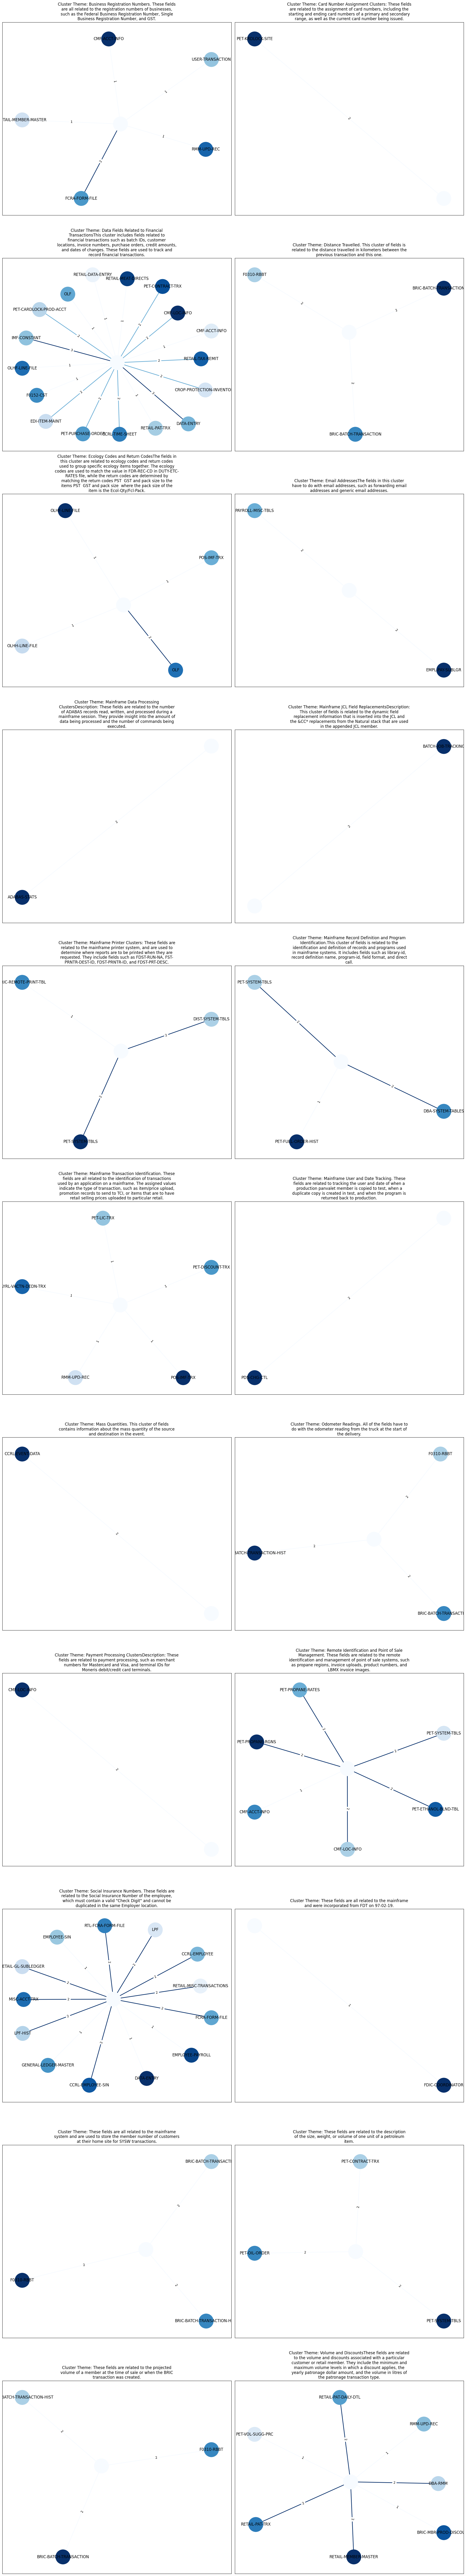

In [17]:
plot_network(results_dbs)

## $Spectral$ (Hierarchical) `semi-supervised` Clustering Clustering Method

### Why Spectral Clustering

- Spectral clustering does not require the user to specify the number of clusters in advance.
- Spectral clustering can handle data sets with complex or non-linear patterns, as it uses the eigenvectors of a similarity matrix to identify clusters.
- Spectral clustering is robust to the presence of noise and outliers in the data, as it can identify clusters even if they are surrounded by points that are not part of the cluster.
- Spectral clustering can identify clusters with arbitrary shapes, as it does not impose any constraints on the shape of the clusters.

## Implementation

In [18]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

df_spec = source.copy()
n_clusters = 4

# Compute pairwise similarities between data points using cosine similarity
similarities = cosine_similarity(matrix)
# Construct graph from similarities matrix
G = np.triu(similarities, k=1)
# Initialize kmeans object with n_clusters
kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
# Fit kmeans to graph
kmeans.fit(G)
# Predict cluster labels for each data point
labels_spec = kmeans.labels_

df_spec["Cluster"] = labels_spec

df_spec.groupby("Cluster").Level.mean().sort_values()

/Users/anuragsinha/anaconda3/envs/KMEANS/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Cluster
2    1.561265
1    1.592437
0    1.720165
3    1.744361
Name: Level, dtype: float64

In [19]:
plot_tsne(data=df_spec, matrix=matrix, plot_lib=PlotType.PX)

<Figure size 1600x800 with 0 Axes>

In [20]:
results_spec = embeddings_to_LLM(data=df_spec)

## Cluster 0 Theme:



###  Date and Identification Clusters: These fields are related to dates and identification numbers used to track and record information related to retail transactions.





- __RETAIL-PAT-MASTER__ :A super descriptor used to check to see if a patronage code for a particular retail is being used on any of the record types. (1). 



- __IMF-CONSTANT__ :Last date of inventory adjustment. (3). 



- __RTL-FINANCE-STMT-ADJ__ :A date indicating to which retail's accounting period the transaction applies. (1). 



- __RTL-FCRA-FORM-FILE__ :The date a T4 or T4A was amended.  Original forms have a date of 0  amended ones have their date of creation. (2). 



- __RETAIL-ACCUMULATED-EARNINGS__ :Productivity Report Field - The date of the start of   the payroll week. This   will always be a Sunday. (2). 



- __CCRL-TIME-SHEET__ :A date (CCYYMMDD) indicating to which accounting period the transaction applies. (2). 



- __CCRL-CONTINUOUS-NOTES__ :This field contains the date that this note record was created or last modified. (2). 



- __RTL-AR-STMTS-HIST__ :Printer destination or the userid of the requester. This is shown by the field FUT-USER-DEST-CD. (1). 



- __IMF-CONSTANT__ :THE DATE THE LAST DEMAND UPDATE WAS DONE. (2). 



- __OLHF-LINE-FILE__ :A CODE used to group specific ecology items together. EX. ALL 2 LITRE BOTTLES. Each item on the IMFS system with an ecology code must have a corresponding return code. The return code is determined by matching the return codes PST  GST and pack size to the items PST  GST and pack size  where the pack size of the item is the Ecol-Qty/Fcl-Pack. (1). 



- __EDI-ITEM-MAINT__ :The first available ship date of the product.  This is sent in the edi 832 transaction. (2). 



- __CMF-LOC-INFO__ :The remote number where the price upload file is sent for this location.  The remote number may be another retails remote number as they may do their pricing. It is a translation of the remote number into an identification field. eg. rmt094 = RTLCAL1 (2). 



- __PET-PURCHASE-ORDER__ :The date the items specified on the purchase order are to be shipped to the warehouse. (1). 



- __ROUTE-NAME-TBLS__ :The payables vendor number. The vendor may have several merchandising vendor numbers  as such  the payables vendor number identifies the vendor location that is to be paid. (2). 



- __PET-CUSTOMER-MASTER__ :The date the corresponding commission rate is to start being effective if the rate is set. (2). 



- __RETAIL-MEAT-DIRECTS__ :If someone over-rides the order stop date  this will show the user-id of the person who changed it. (1). 



- __OHF__ :The vendor number of the carrier used to transport retail orders. (2). 



- __CCRL-TRAINING-HISTORY__ :The user-id that made the last change. (1). 



- __CMF-LOC-INFO__ :A license number required to enable the customer location to purchase exempt of provincial sales tax. (2). 



- __RETAIL-DATA-ENTRY__ :A field used to identify the batch being processed. Consists of the user-id that created the record. (2). 



## Cluster 1 Theme:



###  Mainframe Data Clusters: This cluster includes fields related to mainframe data, such as user IDs, dates, transaction IDs, and descriptions. These fields are used to store and track information related to mainframe systems.





- __CCRL-TIME-SHEET-RESTRICTED__ :The date that a sick leave occurrence started.  Will only be filled in if the sick leave is a continuation of a previous occurrence. (2). 



- __DBA-SYSTEM-TABLES__ :The user's logon-id. (2). 



- __CROP-PROTECTION-INVENTORY__ :Superdescriptor consisting of: fcpi-stat FCPI-RTL-INVT-TYP-ID (1). 



- __EMPLOYEE-PAYROLL__ :The date when the employee is due for a special review. This date does not affect their normal review date. (2). 



- __BRIC-BATCH-TRANSACTION-HIST__ :The date to be used when creating the weekly reconciliation reports. (2). 



- __RECEIPTS-ADJUSTMENTS__ :The name of the program that created the price history trailer (and updated the current price on the RAFI record). (2). 



- __BRIC-BATCH-TRANSACTION-HIST__ :The reference id that a keyer may optionally enter on a delivery slip. (2). 



- __F0310-RBBT__ :This is the member's projected volume at time of sale or when the BRIC transaction was created. (2). 



- __CCRL-TIME-SHEET-RESTRICTED__ :A date (CCYYMMDD) indicating to which accounting period the transaction applies. (2). 



- __DATA-ENTRY__ :The tonnage quantity of an A/R adjustment entry. (1). 



- __RCF-CONSTANT-FILE__ :A date indicating to which retail's accounting period the transaction applies. (1). 



- __EMPLOYEE-PAYROLL__ :The date when the employee is due for their next review. Next Appraisal Date is not used for management employees. (2). 



- __DIST-SYSTEM-TBLS__ :Printer Destination (2). 



- __EMPLOYEE-PAYROLL__ :The adjusted start date of the employee with the current employer. (1). 



- __RECEIPTS-ADJUSTMENTS__ :The time that the FRA record was stored. Value are: hour min sec 1/10th second. (hhmmss1) (1). 



- __RCF-CONSTANT-FILE__ :The user id of the person who transferred this claim. (2). 



- __RMM-UPD-REC__ :Transaction identification used by an application. Assigned values to-date: IMFPOS   - Item/price upload PROMSCAN - TGP prom scan upd TCIUPLD  - Promotion records  to send to TCI. POSNEW   - New food direct  item for FCL upload wait 1  work day before send out. PROMUPLD - FCL Prom Upload rec UPLDPRC  - Items that are to  have retail selling prices  uploaded to particular retail (1). 



- __PET-SYSTEM-TBLS__ :The date the current rate expires. (2). 



- __GENERAL-NOTES__ :Identifies the department that is to receive the timeline information. Everyone identified in this department will become a recipient. (2). 



- __DBA-SYSTEM-TABLES__ :The date that the file was cop ied down from CBT. (2). 



## Cluster 2 Theme:



###  Data Storage and RetrievalThis cluster of fields is related to data storage and retrieval. These fields are used to store and access information from various sources, such as mainframe systems, databases, and other sources. They are used to track and store information such as customer information, financial data, and other data related to transactions.





- __ADABAS-STATS__ :The number of ADABAS assoc records written during the ADABAS session. (2). 



- __FUNDS-TABLE__ :The particular funds current months amount collected. (2). 



- __PANVALET-CHG-CTL__ :Super to find old change ctrl. Consists of: FPA-STAT FPA-INIT-COPY-DATE (1). 



- __F0310-RBBT__ :THIS IS USED FOR SYSW 'S' TRANSACTIONS.  IT WILL CONTAIN THE MEMBER NUMBER OF THE CUSTOMER AT THEIR HOME SITE. (2). 



- __BANK-CLEARING__ :The original cheque or reference number if the number has been modified. (2). 



- __POF-CONSTANT__ :The vendor invoice number. (2). 



- __CCRL-CONTRACTOR-ACTIVITY__ :The vendor invoice number. (2). 



- __ADABAS-STATS__ :The number of format translations that occurred during the ADABAS session. (2). 



- __BRIC-RTL-VOL-HISTORY__ :This is the amount short per week. (2). 



- __BATCH-JOB-TRACKING__ :The &CC* replacements from the Natural stack that were used in the appended JCL member. (2). 



- __F0310-RBBT__ :The unit # entered at the cardlock when fuel is picked up. . If the unit # is not entered then this field will be blank. . This field is used by the cardlock unit/card reports. . These reports give the unit and card information for cardlock invoices. (2). 



- __CCRL-STORES-ACTIVITY__ :The vendor invoice number. (2). 



- __EMPLOYEE-PAYROLL__ :The social insurance number of the employee.  Must contain a valid "Check Digit". Duplicate SIN numbers cannot be set up in the same Employer location. (1). 



- __AR-SUMMARY-DATA__ :The total number of debit transactions for the commodity group since last November. (3). 



- __F0704-RCF__ :The vendor invoice number. (2). 



- __PAYROLL-MISC-TBLS__ :This a generic email address field. (2). 



- __EMPLOYEE-PAYROLL__ :THE SERIAL NUMBER OF THE ORIGINAL ISSUED ROE  WHEN AN EMPLOYEE IS ISSUED AN AMENDED REPORT. (2). 



- __RETAIL-MEMBER-MASTER__ :The volume in litres of the patronage transaction type as applied to the retail member. (2). 



- __FDIC-COORDINATOR__ :This field was incorporated from FDT on 97-02-19 (1). 



- __BRIC-RTL-VOL-HISTORY__ :This is carried over from the actual inventory of the last week. (2). 



## Cluster 3 Theme:



###  Financial and Accounting DataThis cluster of fields is related to financial and accounting data, such as amounts, invoices, payments, and taxes. These fields are used to track and calculate financial information, such as GST, credit invoices, debit amounts, and disputed amounts. Additionally, these fields are used to track budget volumes, distances travelled, and social insurance numbers.





- __MISC-ACCT-TRX__ :The amount of the GST charged on the invoice. (2). 



- __AR-SUMMARY-DATA__ :The amount of all credit invoices processed within the last month. (1). 



- __RETAIL-TRUCK__ :This is the amount spent on communication expenses. (2). 



- __RETAIL-AR-SUMMARY__ :The total amount purchased since January for the charge or revolving account type. (2). 



- __DOF-ITEM__ :Superdescriptor consisting of: FDO-NO FDI-SEQ-NO (1). 



- __CCRL-TAG-MASTER__ :This field is an estimated maximum value for this Tag. (2). 



- __AR-SUMMARY-DATA__ :The debit amount by day for the current period  for the invoices that are to be paid immediately. (2). 



- __AR-SUMMARY-DATA__ :The total amount of all disputed invoices for the customer. The amount in question will be reflected in the customer's current aging until the dispute has been resolved. (2). 



- __AR-TRANSACTIONS__ :The portion of the invoice that the customer disputes as being owing. (2). 



- __RETAIL-LOANS__ :The amount owing for the period. (2). 



- __DATA-ENTRY__ :This field will keep track of the total amount for all non-tax (mainly gst) gl's entered in an FPAY invoice that is needed for various calculations. (1). 



- __BRIC-BATCH-TRANSACTION-HIST__ :The distance travelled in kilometers between the previous transaction and this one. (2). 



- __RETAIL-GL-BUDGET__ :Budget volume. (2). 



- __RETAIL-DATA-ENTRY__ :Budget volume. (2). 



- __RCF-CONSTANT-FILE__ :The total value of an entry in a claim. (1). 



- __DBA-RMM__ :The retail member's social insurance number. (1). 



- __RETAIL-MEMBER-MASTER__ :The retail member's social insurance number. (1). 



- __PET-CARDLOCK-TRANSACTION-HIST__ :The original GST calculated for the transaction. (1). 



- __DATA-ENTRY__ :The standard entry invoice amount in FPAY that must be split into future periods. (3). 



- __DATA-ENTRY__ :The ending cheque number in a cheque range used by rss for stop cheque processing. (1). 



---

# __Identified Themes__

- Cluster Theme: Date and Identification Clusters: These fields are related to dates and identification numbers used to track and record information related to retail transactions.

- Cluster Theme: Mainframe Data Clusters: This cluster includes fields related to mainframe data, such as user IDs, dates, transaction IDs, and descriptions. These fields are used to store and track information related to mainframe systems.

- Cluster Theme: Data Storage and RetrievalThis cluster of fields is related to data storage and retrieval. These fields are used to store and access information from various sources, such as mainframe systems, databases, and other sources. They are used to track and store information such as customer information, financial data, and other data related to transactions.

- Cluster Theme: Financial and Accounting DataThis cluster of fields is related to financial and accounting data, such as amounts, invoices, payments, and taxes. These fields are used to track and calculate financial information, such as GST, credit invoices, debit amounts, and disputed amounts. Additionally, these fields are used to track budget volumes, distances travelled, and social insurance numbers.

---

# Identified 76 duplicates.

                      Source                      Target Score
75                   DBA-RMM        RETAIL-MEMBER-MASTER   100
73          RETAIL-GL-BUDGET           RETAIL-DATA-ENTRY   100
45              POF-CONSTANT    CCRL-CONTRACTOR-ACTIVITY   100
46              POF-CONSTANT        CCRL-STORES-ACTIVITY   100
47              POF-CONSTANT                   F0704-RCF   100
50  CCRL-CONTRACTOR-ACTIVITY        CCRL-STORES-ACTIVITY   100
51  CCRL-CONTRACTOR-ACTIVITY                   F0704-RCF   100
5            CCRL-TIME-SHEET  CCRL-TIME-SHEET-RESTRICTED   100
3       RTL-FINANCE-STMT-ADJ           RCF-CONSTANT-FILE   100
59      CCRL-STORES-ACTIVITY                   F0704-RCF   100


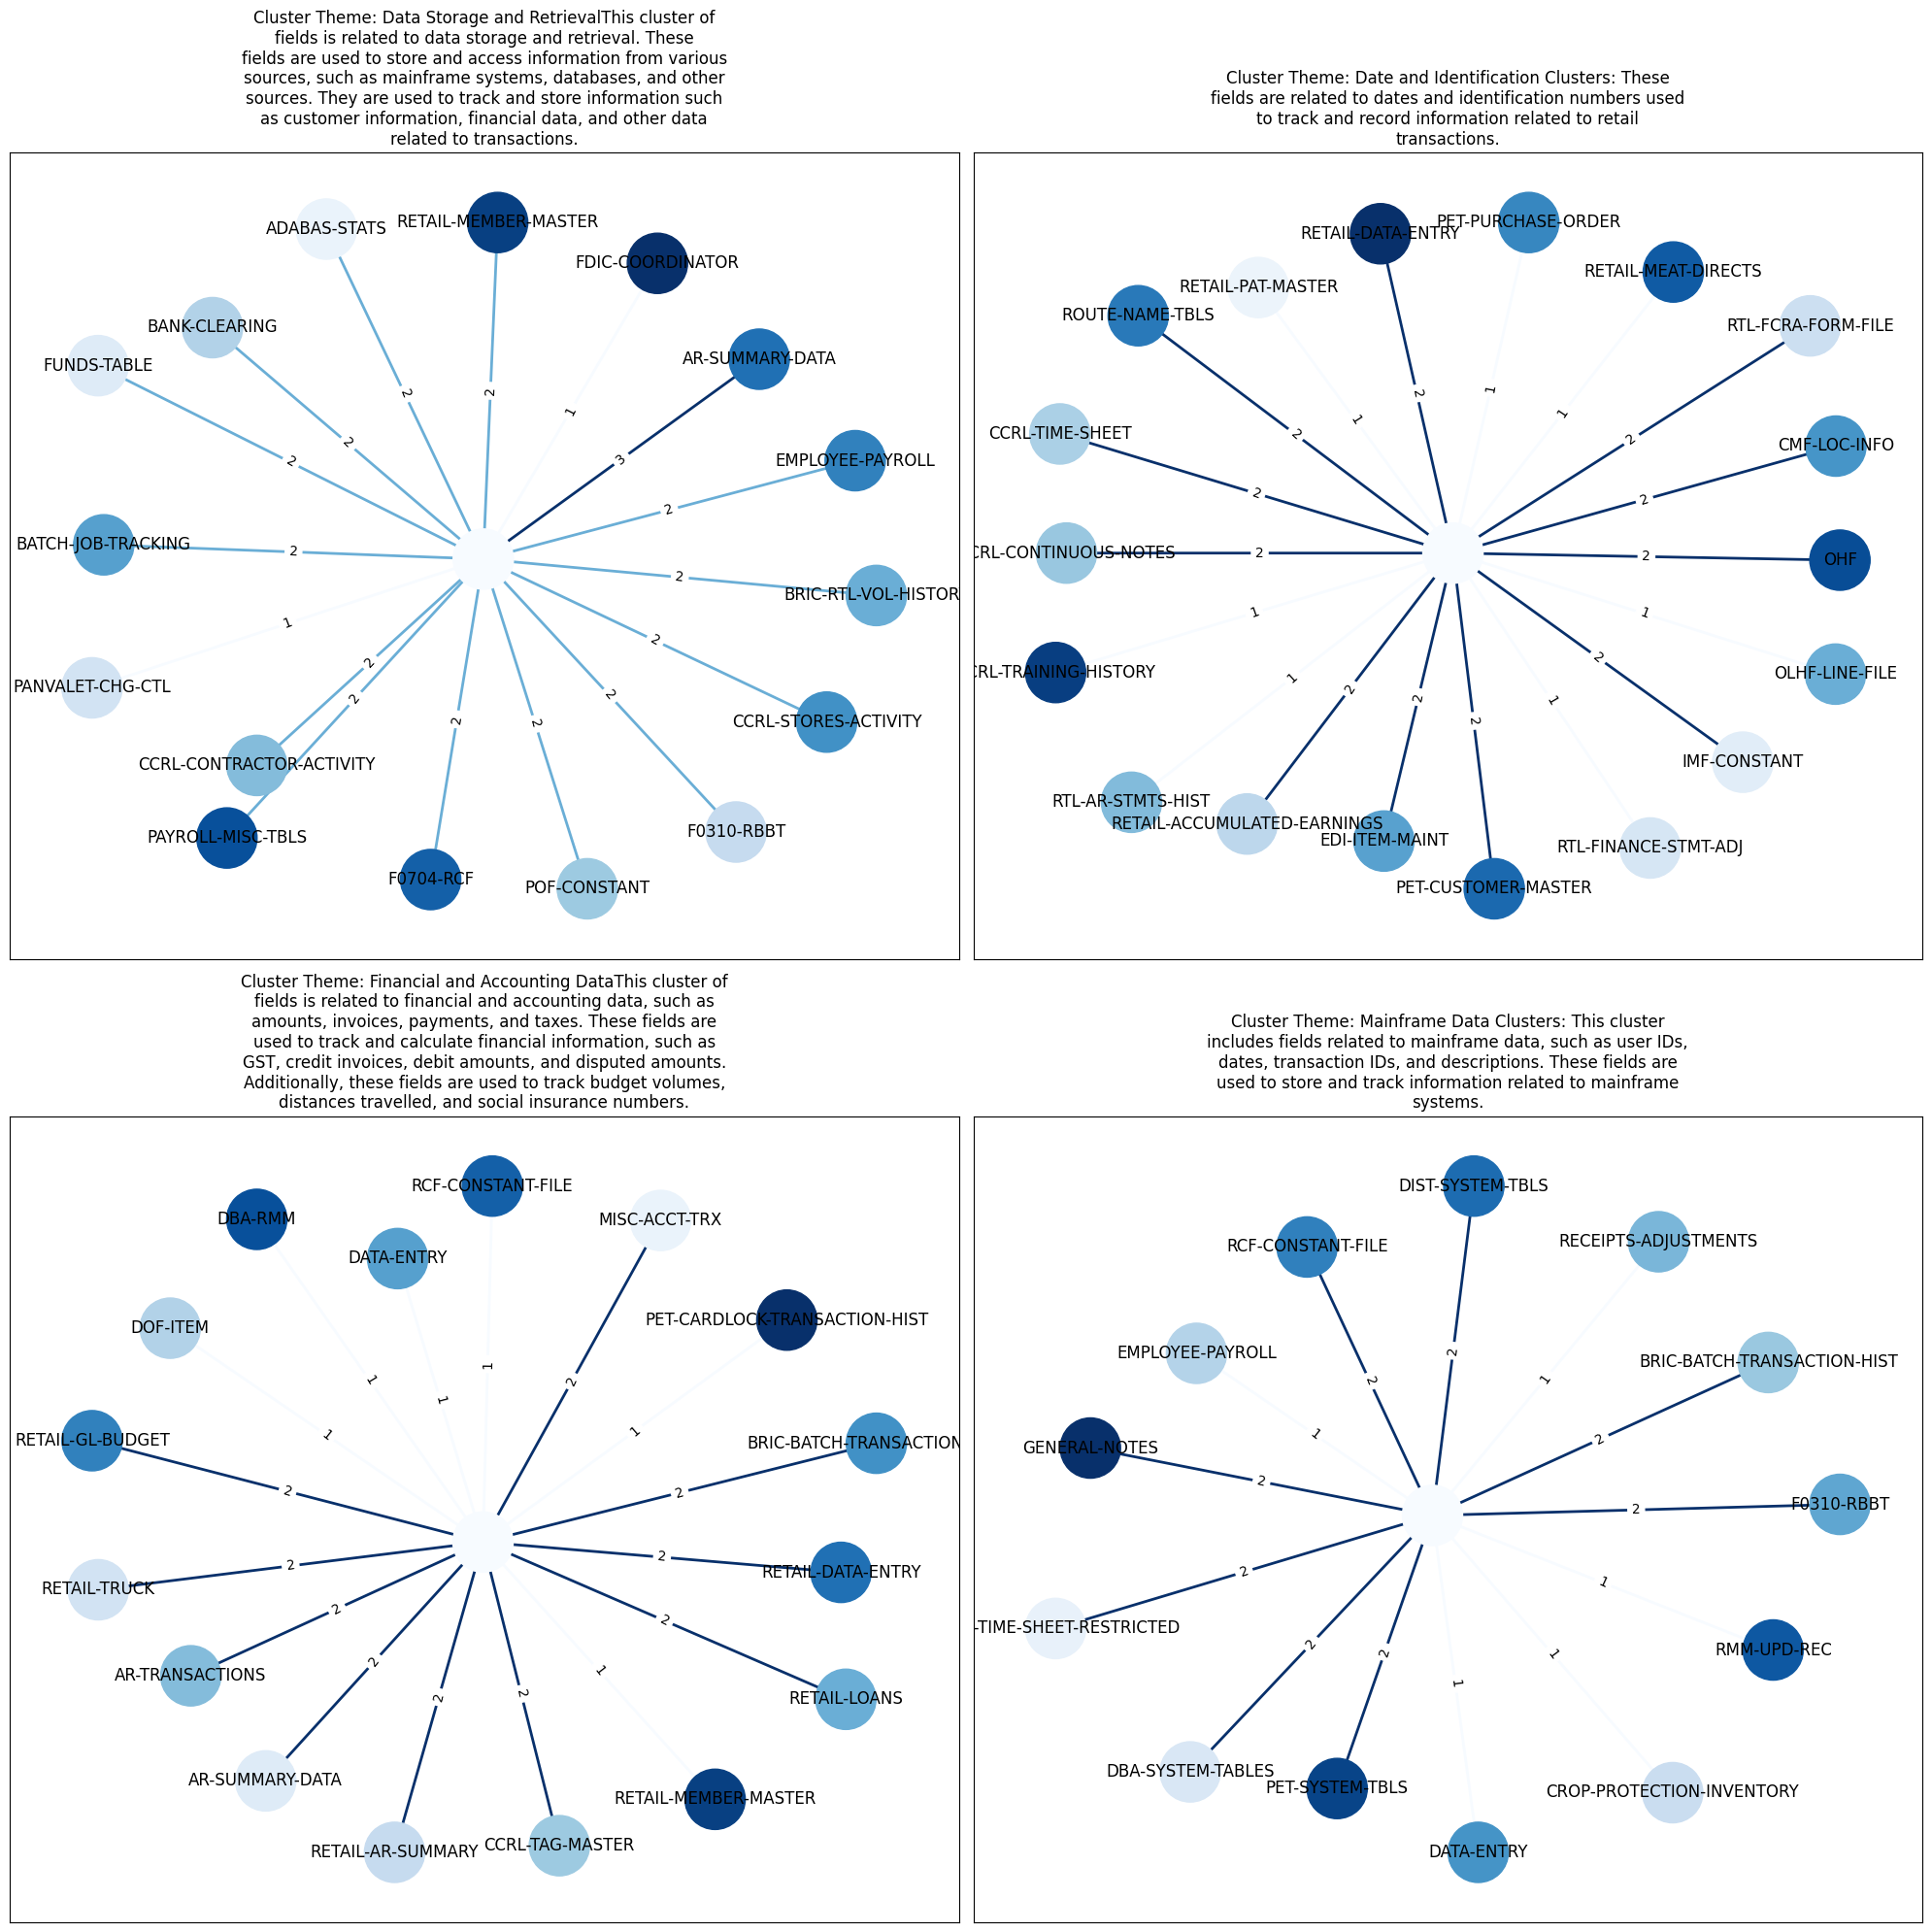

In [21]:
plot_network(results_spec)

## Evaluation

In [22]:
# Evaluation
from sklearn.metrics import silhouette_score

# Compute silhouette score for each data point
scores_kmeans = silhouette_score(matrix, labels)
scores_dbs = silhouette_score(matrix, labels_dbs)
scores_spec = silhouette_score(matrix, labels_spec)
# Compute mean silhouette score
ms_kmeans = np.mean(scores_kmeans)
ms_dbs = np.mean(scores_dbs)
ms_spec = np.mean(scores_spec)
print('KMEANS: Mean silhouette score =', ms_kmeans)
print('DBSCAN: Mean silhouette score =', ms_dbs)
print('SPECTRAL: Mean silhouette score =', ms_spec)
print(f"Maximum Score observed as {max(ms_kmeans, ms_dbs, ms_spec)}")

KMEANS: Mean silhouette score = 0.07766394389823475
DBSCAN: Mean silhouette score = 0.00441952528730407
SPECTRAL: Mean silhouette score = 0.013649773974695184
Maximum Score observed as 0.07766394389823475


# Classification

We will be using `embeddings` we generated to classify clusters. For many text classification tasks, we've seen fine-tuned models do better than embeddings but for the purposes of this exercise we will stick to `zero-shot` mechanisms as they tend to work better in `non-contiguous` scenarios.

In this text classification task, we predict the cluster based on provided field and description data. We split the dataset into a training and a testing set for all the following tasks, so we can realistically evaluate performance on unseen data. The dataset is created in `Data preparation` stage of this notebook.

The `criterion` in `RandomForestClassifiers` is a function that measures the quality of a split. Supported criteria are `gini` for the Gini impurity and `log_loss` and `entropy` both for the Shannon information gain.

## Function

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix)
from sklearn.model_selection import train_test_split

from embeddings_utils import plot_multiclass_precision_recall


def classify_clusters(data, test_size=0.1, random_state=42, plot=True):

    # split data into train and test
    X_train, X_test, y_train, y_test = train_test_split(
        list(data.embedding.values), data.Cluster, test_size=0.2, random_state=42
    )

    # train random forest classifier
    clf = RandomForestClassifier(n_estimators=100, criterion="entropy")
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    probas = clf.predict_proba(X_test)

    report = classification_report(y_test, preds, zero_division=1)
    print(report)


    # classlist for precision-recall graph
    class_list = pd.unique(data["Cluster"]).tolist()
    if plot:
        # Plot #1 - precision and f1 score
        plot_multiclass_precision_recall(probas, y_test, class_list, clf)

        # Plot #2 - Confusion Matrix
        cm = confusion_matrix(y_test, preds)

        # Create labels
        labels = ['Class ' + str(i) for i in range(cm.shape[0])]

        # Create heatmap
        plt.figure(figsize=(10,7))
        sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')

        # Customize aspect
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')

        plt.show()

## Run Classification

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        54
           1       1.00      0.94      0.97        36
           2       1.00      1.00      1.00        56
           3       0.96      1.00      0.98        54

    accuracy                           0.99       200
   macro avg       0.99      0.99      0.99       200
weighted avg       0.99      0.99      0.99       200

RandomForestClassifier(criterion='entropy') - Average precision score over all classes: 0.19


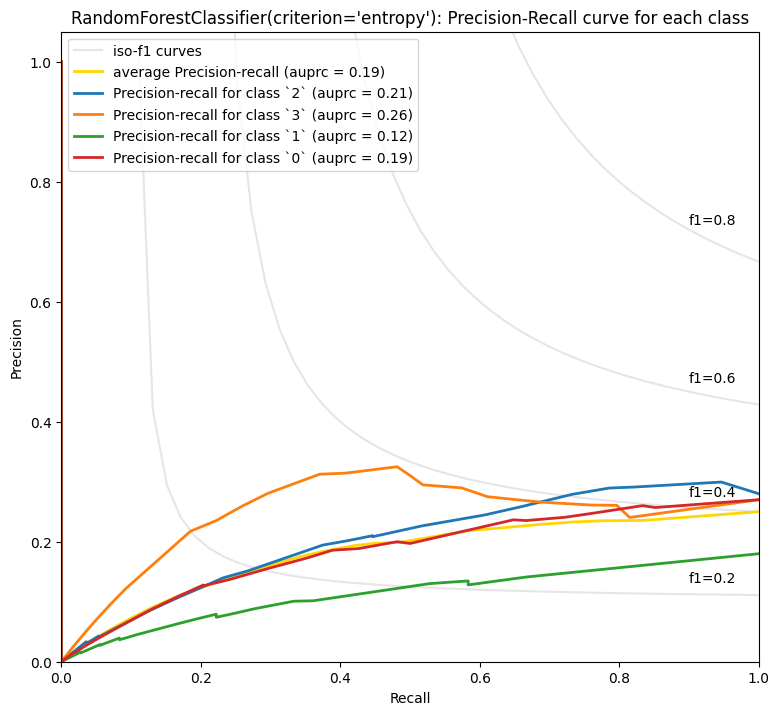

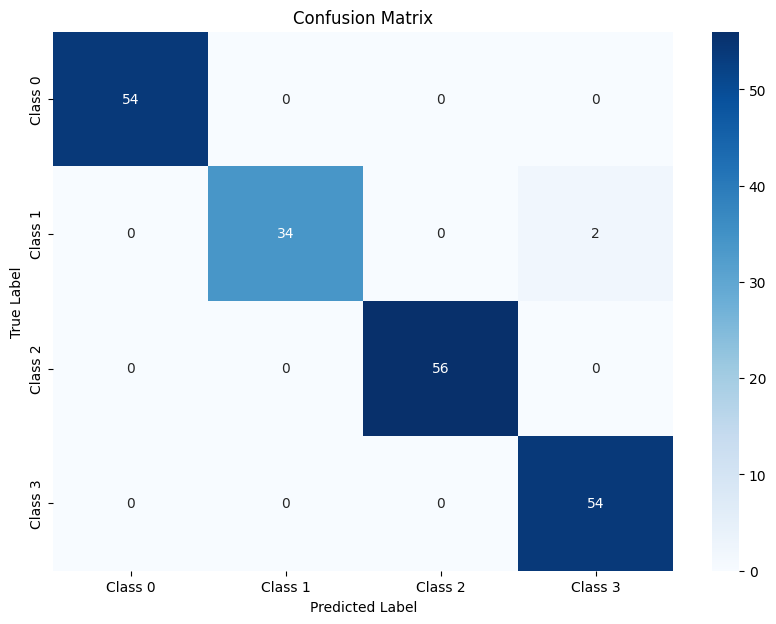

In [24]:
classify_clusters(df)

              precision    recall  f1-score   support

          -1       1.00      0.15      0.26        27
           0       0.83      1.00      0.91       148
           1       1.00      0.50      0.67         4
           2       1.00      0.50      0.67         4
           3       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         1
           7       1.00      0.00      0.00         1
           9       1.00      1.00      1.00         3
          12       1.00      1.00      1.00         1
          13       1.00      0.00      0.00         1
          15       1.00      1.00      1.00         3
          16       1.00      0.50      0.67         2
          18       1.00      0.67      0.80         3

    accuracy                           0.84       200
   macro avg       0.99      0.67      0.71       200
weighted avg       0.87      0.84      0.80       200

RandomForestClassifier(cr

/Users/anuragsinha/anaconda3/envs/KMEANS/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning:

No positive class found in y_true, recall is set to one for all thresholds.

/Users/anuragsinha/anaconda3/envs/KMEANS/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning:

No positive class found in y_true, recall is set to one for all thresholds.

/Users/anuragsinha/anaconda3/envs/KMEANS/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning:

No positive class found in y_true, recall is set to one for all thresholds.

/Users/anuragsinha/anaconda3/envs/KMEANS/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning:

No positive class found in y_true, recall is set to one for all thresholds.

/Users/anuragsinha/anaconda3/envs/KMEANS/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning:

No positive class found in y_true, recall is set to one for all thresholds.

/Users/anuragsinha/anaconda3/envs/K

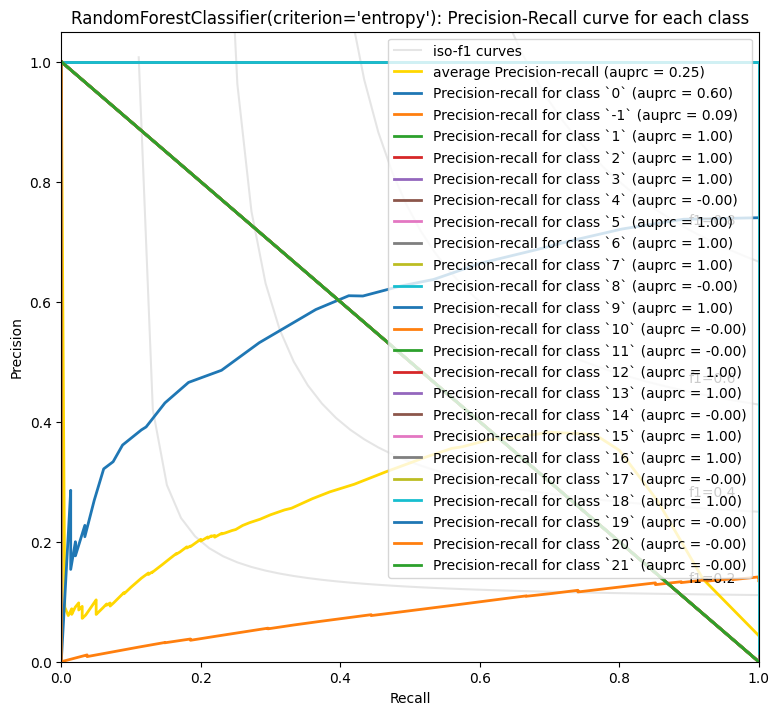

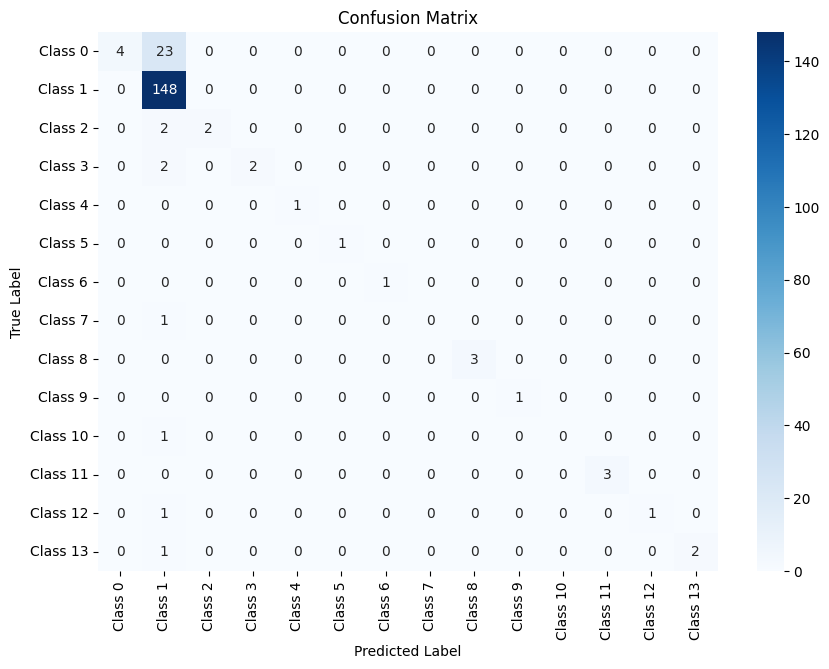

In [25]:
classify_clusters(df_dbs)

              precision    recall  f1-score   support

           0       0.56      0.69      0.62        42
           1       0.61      0.46      0.52        50
           2       0.71      0.71      0.71        55
           3       0.76      0.79      0.78        53

    accuracy                           0.67       200
   macro avg       0.66      0.66      0.66       200
weighted avg       0.67      0.67      0.66       200

RandomForestClassifier(criterion='entropy') - Average precision score over all classes: 0.65


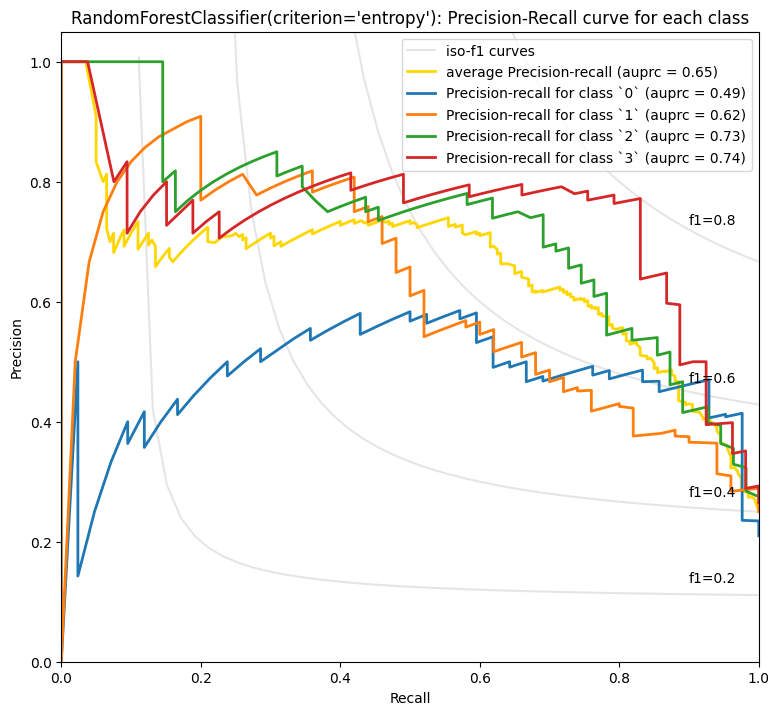

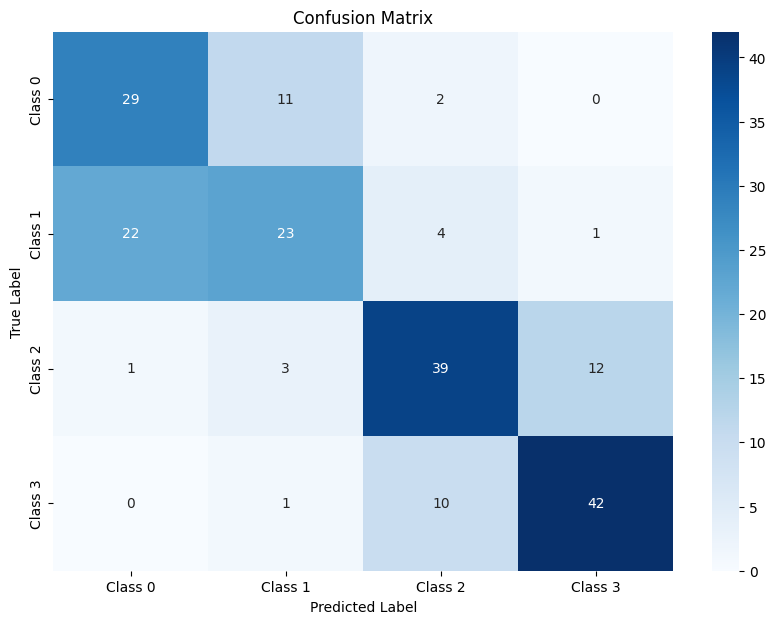

In [26]:
classify_clusters(df_spec)